## **Created By**
- Esteban Arroyave
- Juan Sebastian Plazas
- Juan Guillermo Gómez

In [ ]:
!pip install rich
!pip install ucimlrepo

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype
from scipy.stats import mannwhitneyu
from rich.console import Console
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
import pickle

console = Console()

## **Understanding the dataset**

In [ ]:
# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)
# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets
df_original = pd.concat([X, y], axis=1)
df_original.head()

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  Concrete compressive strength  
0            1040.0           676.0   28                          79.99  
1            1055.0           676.0   28                          61.89  
2             932.0           594.0  270                          40.27  
3             932.0           594.0  365                          41.05  
4             978.4           825.5  360                          44.30

**What is this dataset?**

This dataset is about **Concrete Compressive Strength**. It contains information about the proportions of different ingredients used in a concrete mix, the age of the concrete, and its resulting compressive strength.

**Explanation of each column:**

Here is the explanation of each column shown in the image:

1.  **Cement (component 1) (kg in a m^3 mixture):** Represents the amount of Portland cement used in kilograms per cubic meter of the concrete mix. Cement is the main binder.
2.  **Blast Furnace Slag (component 2) (kg in a m^3 mixture):** Indicates the amount of blast furnace slag used in kilograms per cubic meter. Slag is an industrial byproduct that can be used as a partial substitute for cement to improve certain concrete properties.
3.  **Fly Ash (component 3) (kg in a m^3 mixture):** Shows the amount of fly ash in kilograms per cubic meter. Similar to slag, fly ash is another byproduct that can be used to improve the durability and strength of concrete.
4.  **Water (component 4) (kg in a m^3 mixture):** Is the amount of water used in kilograms per cubic meter of mix. The water-cement ratio is crucial for concrete strength.
5.  **Superplasticizer (component 5) (kg in a m^3 mixture):** Represents the amount of superplasticizer in kilograms per cubic meter. Superplasticizers are additives that allow for a reduction in the water needed while maintaining the workability of the mix, which generally increases strength.
6.  **Coarse Aggregate (component 6) (kg in a m^3 mixture):** Indicates the amount of coarse aggregate (like gravel) in kilograms per cubic meter. Aggregates make up the largest volume of concrete.
7.  **Fine Aggregate (component 7) (kg in a m^3 mixture):** Is the amount of fine aggregate (like sand) in kilograms per cubic meter. Along with coarse aggregate, it provides stability to the mix.
8.  **Age (day):** Is the age of the concrete in days when the compressive strength test was performed. Concrete strength increases over time as the hydration process continues.
9.  **Concrete compressive strength (MPa, megapascals):** This is the **target variable**. It represents the compressive strength of the concrete measured in Megapascals (MPa) at the specified age. This is the value that is being attempted to predict using the other columns as input variables.


- All data are in the same unit of measurement
- The target variable is **Concrete compressive**

**The expected objective** is then to find the model that best predicts the average compressive strength of concrete, based on the variability of other characteristics of its mix and its curing days.

## **EDA**

In [ ]:
df_concrete = df_original.copy()

### **Change Header Names**

In [ ]:
df_concrete.columns = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength']
df_concrete.head()

cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   coarse_aggregate  fine_aggregate  age  compressive_strength  
0            1040.0           676.0   28                 79.99  
1            1055.0           676.0   28                 61.89  
2             932.0           594.0  270                 40.27  
3             932.0           594.0  365                 41.05  
4             978.4           825.5  360                 44.30

In [ ]:
df_concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   blast_furnace_slag    1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasticizer      1030 non-null   float64
 5   coarse_aggregate      1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   age                   1030 non-null   int64  
 8   compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


**Observations:**
- There are a total of 1030 records and 9 features. All of those features are numerics and are in the correct format type.
- There are not null values. Its means, the same number of rows for each column

In [ ]:
df_concrete.describe()

cement  blast_furnace_slag      fly_ash        water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       superplasticizer  coarse_aggregate  fine_aggregate          age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.204660        972.918932      773.580485    45.662136   
std            5.973841         77.753954       80.175980    63.169912   
min            0.000000        801.000000      594.000000     1.000000   
25%            0.000000        932.000000      730.950000     7.000000   
50%            6.400000        968.000000      779.500000    28.000000   
75%           10.200000       1029.400000      824.000000    56.000000   
max           32.200000       1145.000000      992.600000   365.000000   

       compressive_strength  
count           1030.000000  
mean              35.817961  
std               16.705742  
min                2.330000  
25%               23.710000  
50%               34.445000  
75%               46.135000  
max               82.600000

> **Localization and Range Comments**

- The concrete in the data set has an average composition of 281.16 kg/m³, with a range of 102 to 540 kg/m³.
- The concrete studied has an average composition of 86.27 kg/m³ of explosion combustion material, with a range of 0 to 359 kg/m³.
- The concrete studied has an average composition of 54.18 kg/m³ of fly ash, with a range of 0 to 200 kg/m³. In this case, 50% or more of the data equals 0.
- The concrete studied has an average composition of 181.56 kg/m³, with a range of 121.8 to 247 kg/m³. The concrete studied contains an average of 6.20 kg/m³ of superplasticizer, with a range of 0 to 32.2 kg/m³. In this case, 50% or more of the data equals 0 kg/m³.

- The concrete studied contains an average of 972.91 kg/m³ of coarse aggregate, with a range of 801 to 1145 kg/m³.

- The concrete studied contains an average of 773.58 kg/m³, with a range of 594 to 992.66 kg/m³.

- The concrete studied had an average age of 45 days, with a range of 1 day to 365 kg/m³.

- Finally, after compressive strength tests, the concrete studied showed an average of 35.83 MPa, with a range of 2.33 to 82.66 kg/m³.

### **Determine categorical and numeric columns**

In [ ]:
num_cols = [column for column in df_concrete.columns if is_numeric_dtype(df_concrete[column])]
console.print("Numerical Columns:", num_cols)


Numerical Columns:
[
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'fine_aggregate',
    'age',
    'compressive_strength'
]

### **Duplicate Records**

In [ ]:
console.print(f"Number of duplicate records: {df_concrete.duplicated().sum()}")
df_concrete.drop_duplicates(inplace=True)
print(f"Number of duplicate records: {df_concrete.duplicated().sum()}")

Number of duplicate records: 25

Number of duplicate records: 0


A total of 25 records have been deleted due to duplication.

In [ ]:
df_concrete.shape

(1005, 9)

## **Univariate analysis**

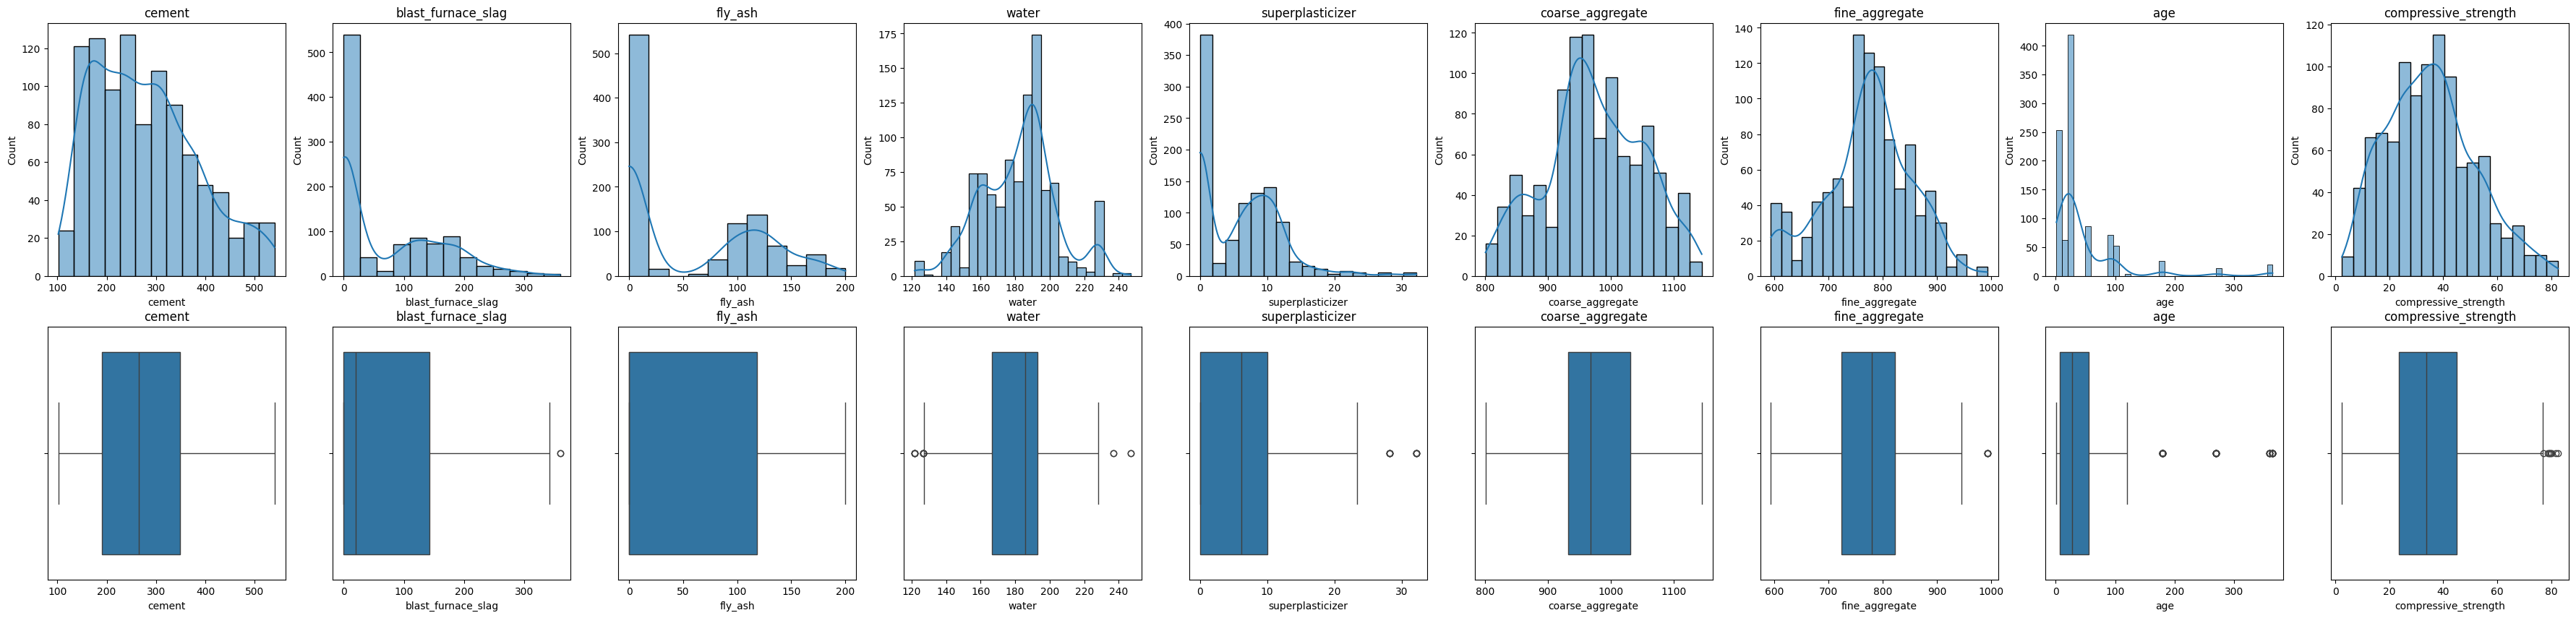

In [ ]:
if num_cols:
    fig, ax = plt.subplots(2, len(num_cols), figsize=(5 * len(num_cols), 10))
    for i, c in enumerate(num_cols):
        sns.histplot(df_concrete[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
        sns.boxplot(x=df_concrete[c], ax=ax[1, i]); ax[1, i].set_title(c)
    plt.show()

Analysis:

Based on the histograms and box plots shown in the image, we can draw the following conclusions about the distribution of variables in the Concrete Compressive Strength dataset:

1.  **Distribution of Components:**
    * **Cement, Water, Coarse Aggregate, and Fine Aggregate:** These components tend to have more concentrated distributions, with shapes that more closely resemble a normal distribution or are slightly skewed. Their box plots show a clear concentration of most data around the median, with some potential outliers at the extremes.
    * **Blast Furnace Slag, Fly Ash, and Superplasticizer:** These components show heavily right-skewed distributions, with a high concentrations of zero values. This suggests that a large portion of the concrete mixes in the dataset do not include blast furnace slag, fly ash, or superplasticizer. The box plots confirm this high concentration at zero and show a much larger spread and numerous outliers for quantities greater than zero.

2.  **Distribution of Age:**
    * The **Age** variable is also heavily right-skewed. The peaks in the histogram at early ages (like 7, 28, 56 days, which are common for strength tests) are very noticeable. The box plot shows that most tests are performed at relatively young ages, with a long tail of potential outliers corresponding to tests at much older ages (up to 365 days).

3.  **Distribution of Compressive Strength:**
    * The target variable, **Concrete compressive strength**, shows a distribution that is more symmetrical than some of the skewed input variables (like slag or age), although it may have a slight right skew. The box plot indicates a range of strength values and some potential outliers at the upper end.

4.  **Presence of Outliers:**
    * Acording with the box plots there are presence of outliers in almost all variables. They are particularly noticeable in the heavily skewed variables (Blast Furnace Slag, Fly Ash, Superplasticizer, Age) and also visible in Cement, Water, Coarse Aggregate, Fine Aggregate, and Concrete compressive strength.


**We will study whether these variables with the presence of zeros present differences when dichotomized and their compressive strength compared.**

In [ ]:
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import zscore

stat, p = shapiro(df_concrete['compressive_strength'])
print(f" Valor p : {p:.3f}")

 Valor p : 0.000


The response variable is not normal, so we use the Mann-Whitney U test, which evaluates whether there is a significant difference between the medians of two groups of data, without assuming a normal distribution.

In [ ]:

def average_comparison(df,col):
  grupo_sin = df[df[col] == 0]['compressive_strength']
  grupo_con = df[df[col] > 0]['compressive_strength']
  stat, p = mannwhitneyu(grupo_sin, grupo_con, alternative='two-sided')
  if p < 0.05:
    console.print(f"{col}","Reject H0: There are significant differences between the medians of both groups")
  else:
    console.print(f"{col}","Does not reject H0: There is no significant evidence between the medians of both groups")

In [ ]:
average_comparison(df_concrete,'blast_furnace_slag')
average_comparison(df_concrete,'fly_ash')
average_comparison(df_concrete,'superplasticizer')

blast_furnace_slag Reject H0: There are significant differences between the medians of both groups

fly_ash Does not reject H0: There is no significant evidence between the medians of both groups

superplasticizer Reject H0: There are significant differences between the medians of both groups

Based on the results obtained, Blast and Superplasticizer were selected to perform a multivariate comparative analysis of the dispersion between characteristics in the presence of these components. **Also, the Fly Ash variable could be discarded; however, a decision will be made in this regard in the variable selection section.**

### **Multivariate Analysis**

First of all, a pairplot is shown, with the response variable transformed into categories using thresholds at 15, 30, 45, 60, and 75 MPa. It is represented using a violet color scale, where darker shades indicate higher compressive strength (Mpa). Let’s take a look:

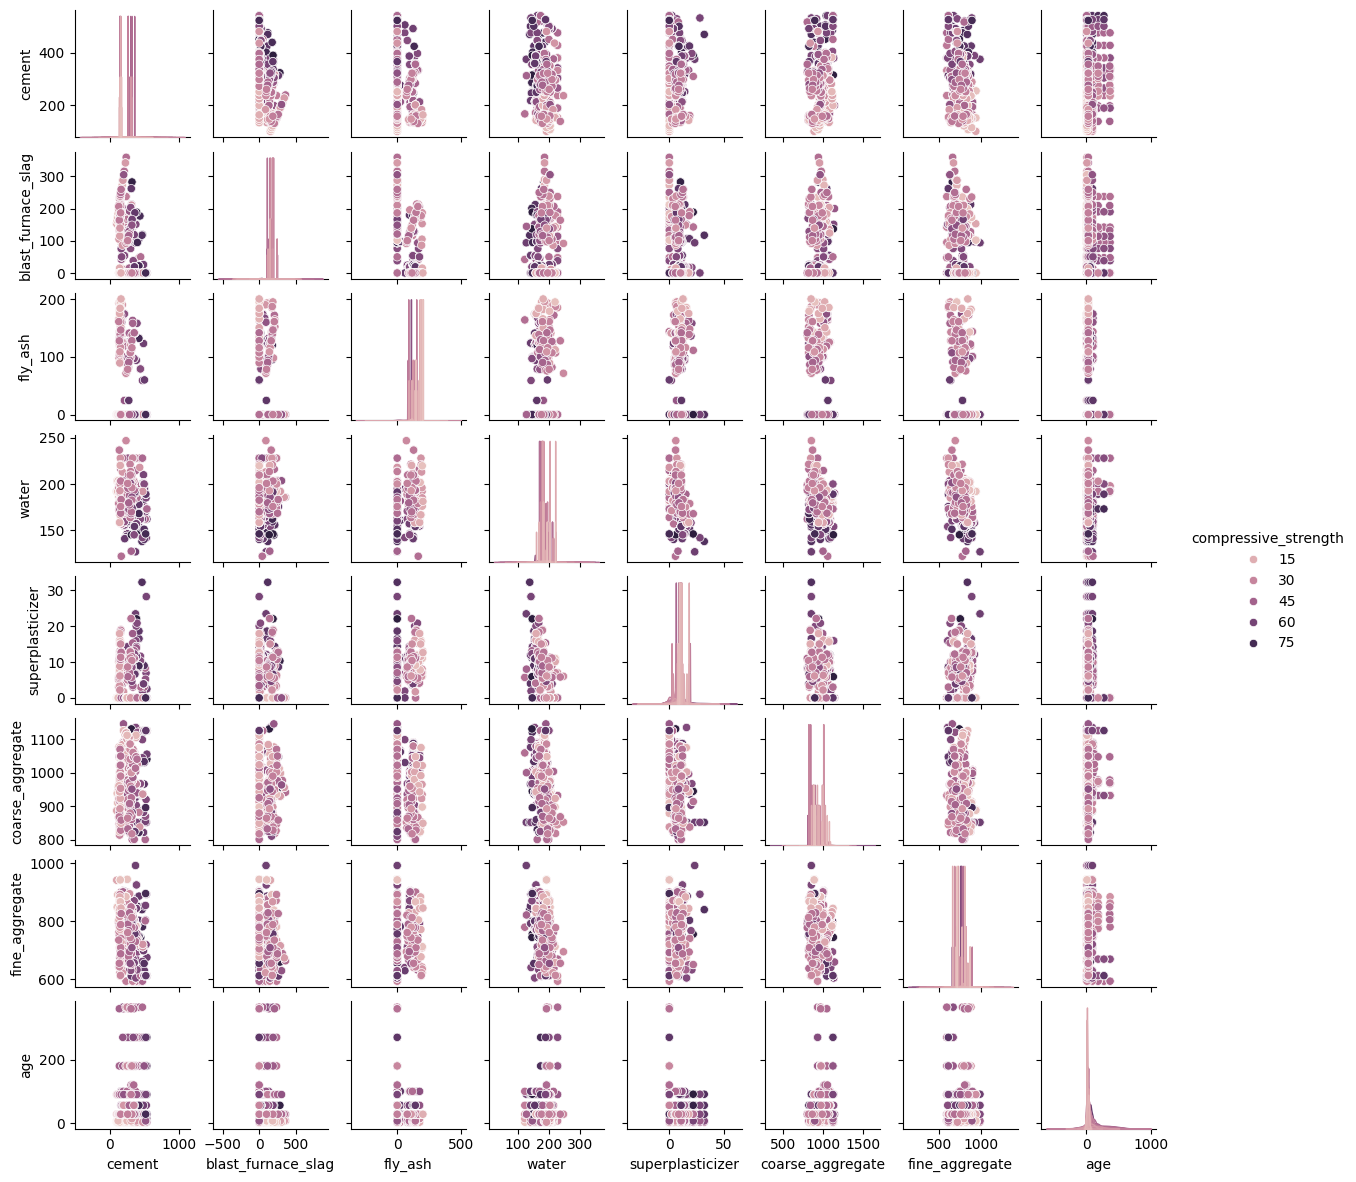

In [ ]:
columns_analysis = ["compressive_strength"]
for i in range(0, len(columns_analysis)):
  hue_num = columns_analysis[i]
  sns.pairplot(df_concrete,hue=hue_num,height=1.5)

> **Analysis:**

- Meanwhile the Cement is higher the compressive strength is higher too
- Meanwhile the water is lower the compressive strength is higher

There are no other evident groupings in the diagrams. Additionally, according to the structure of the pair plots, no strong linear relationships between the predictors are observed.

Now, let's examine a multivariable analysis involving Blast Furnace Slag and Superplasticizer, considering whether the mixture contains these components or not.

In [ ]:
df_concrete['Blast_used'] = (df_concrete['blast_furnace_slag'] > 0).astype(str)
df_concrete['Superplasticizer_used'] = (df_concrete['superplasticizer'] > 0).astype(str)

In [ ]:
cat_cols = [c for c in df_concrete.columns if is_string_dtype(df_concrete[c])]

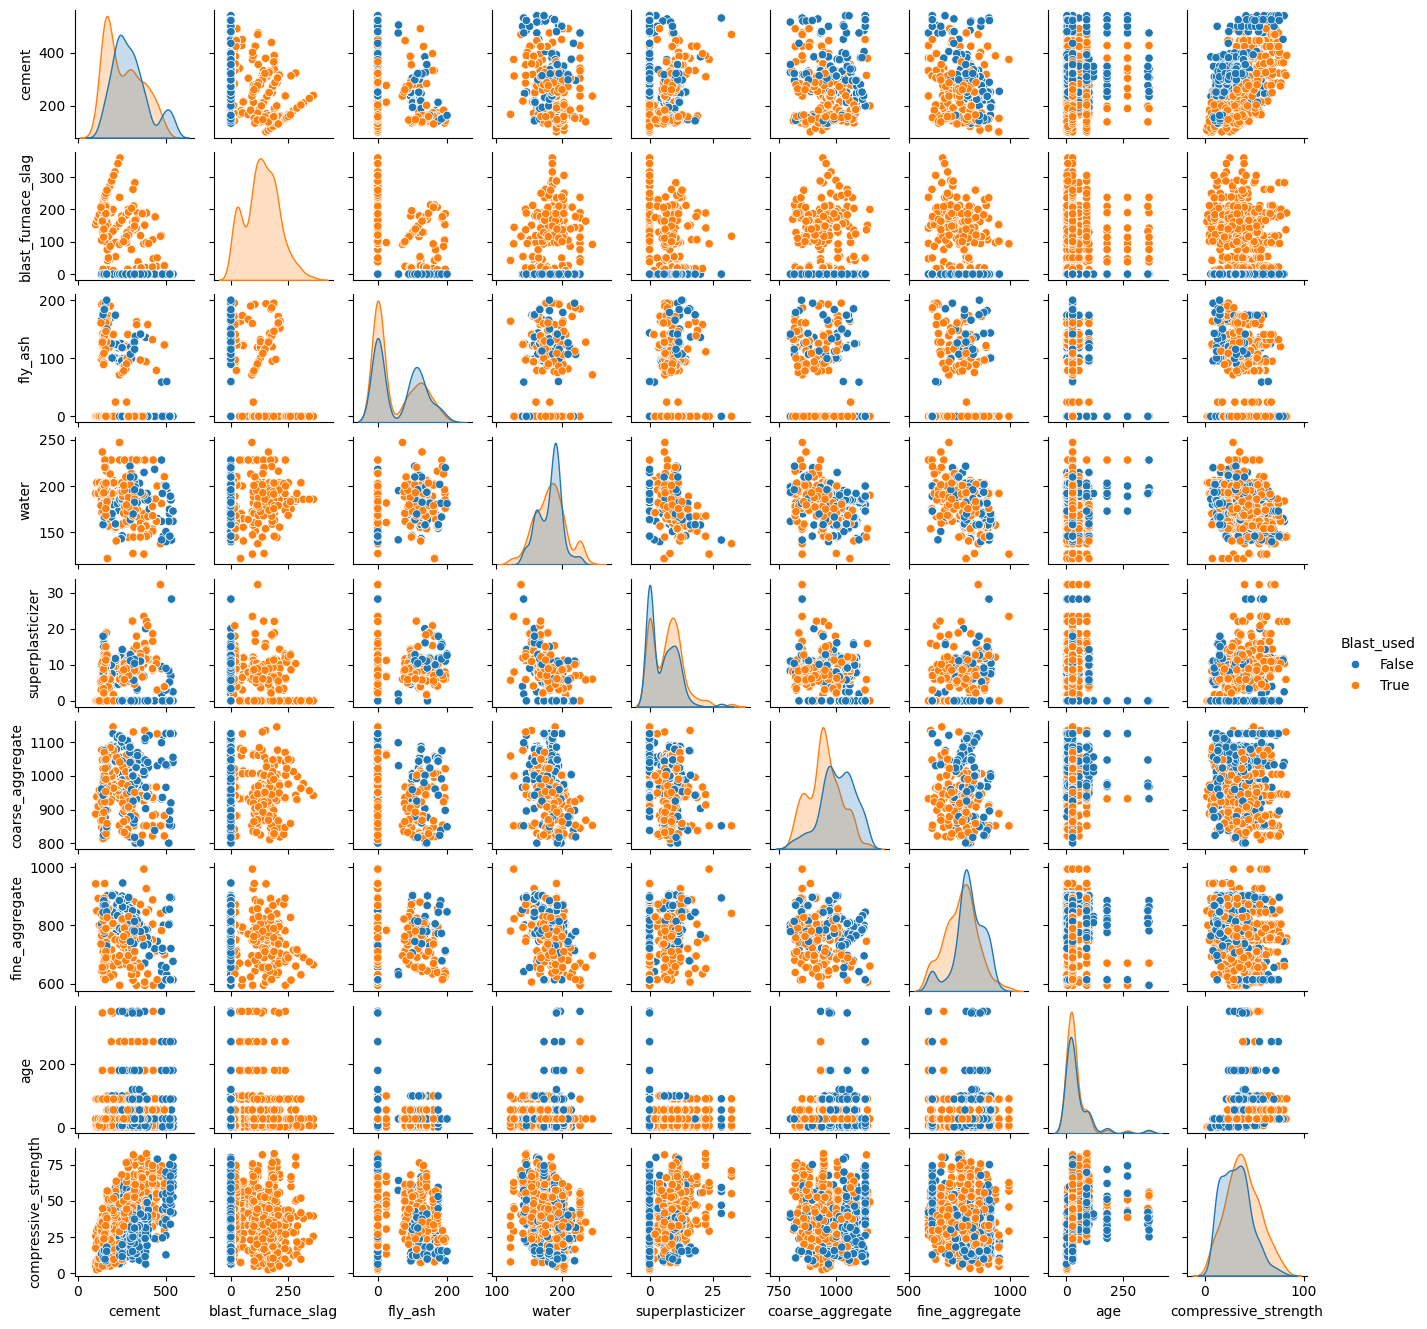

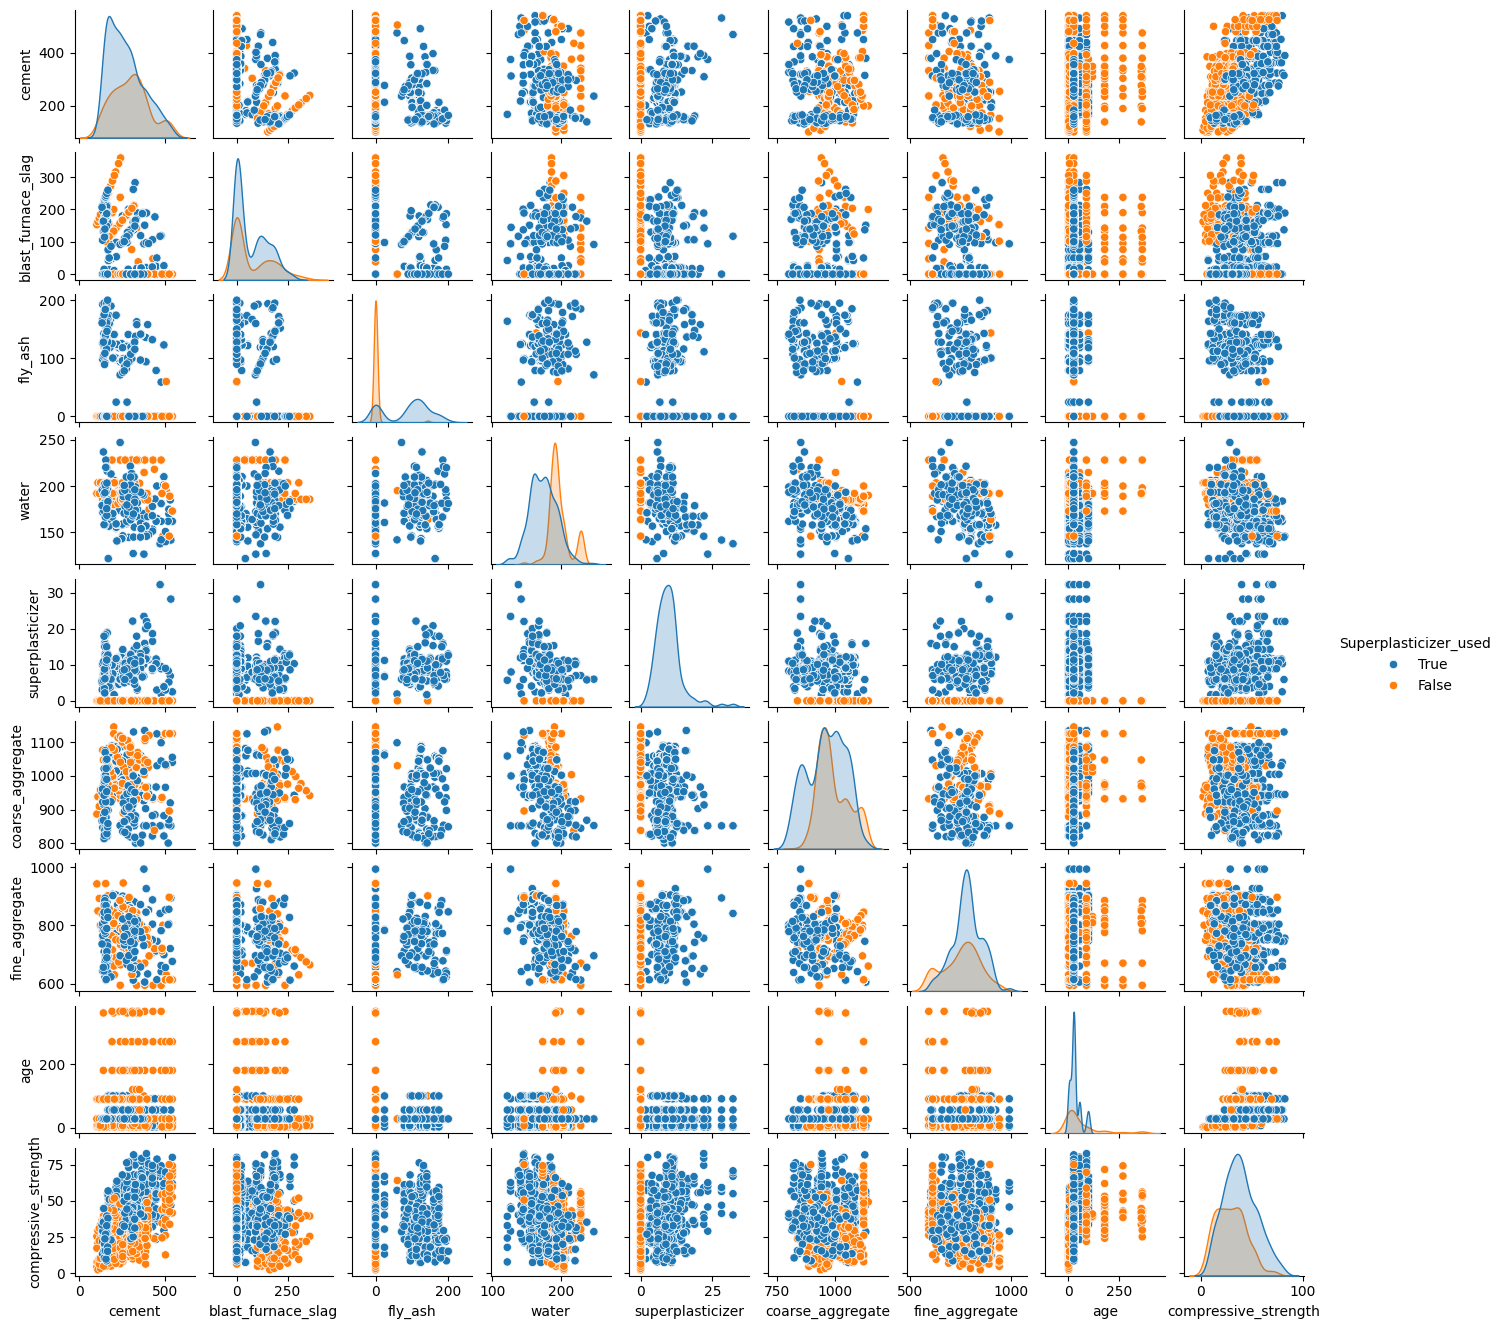

In [ ]:
for i in range(0, len(cat_cols)):
  hue_cat = cat_cols[i]
  sns.pairplot(df_concrete, hue=hue_cat,height=1.5)

**GRAPHIC 1 - With or without Blast:**

The presence of Explosion generates a graphic differentiation between the distributions of the following components:

- Coercive Aggregate: It is weak, but it appears that concrete mixtures without Explosion have a higher coercive aggregate component.

- Compressive Strength: Despite significant differences between their means, there does not appear to be a graphic distinction between the presence or absence of the Explosion component.

**GRAPHIC 2 - With or without Superplasticizer:**

The presence of superplasticizer generates a visual differentiation between the distributions of the following components:

- Water: Although weak, it appears that in the presence of Explosion, it is greater in concrete mixtures with less water.

- Fly Ash: These two components appear to have a direct relationship, since the presence of superplasticizer increases the fly ash component.

- With the variable of interest, no demarcation is shown between the distributions based on the presence or absence of this component in the concrete.

### **Remove Outliers**

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df


for col in num_cols:
    df_concrete = remove_outliers_iqr(df_concrete, col)


### **Dataset without Outliers**

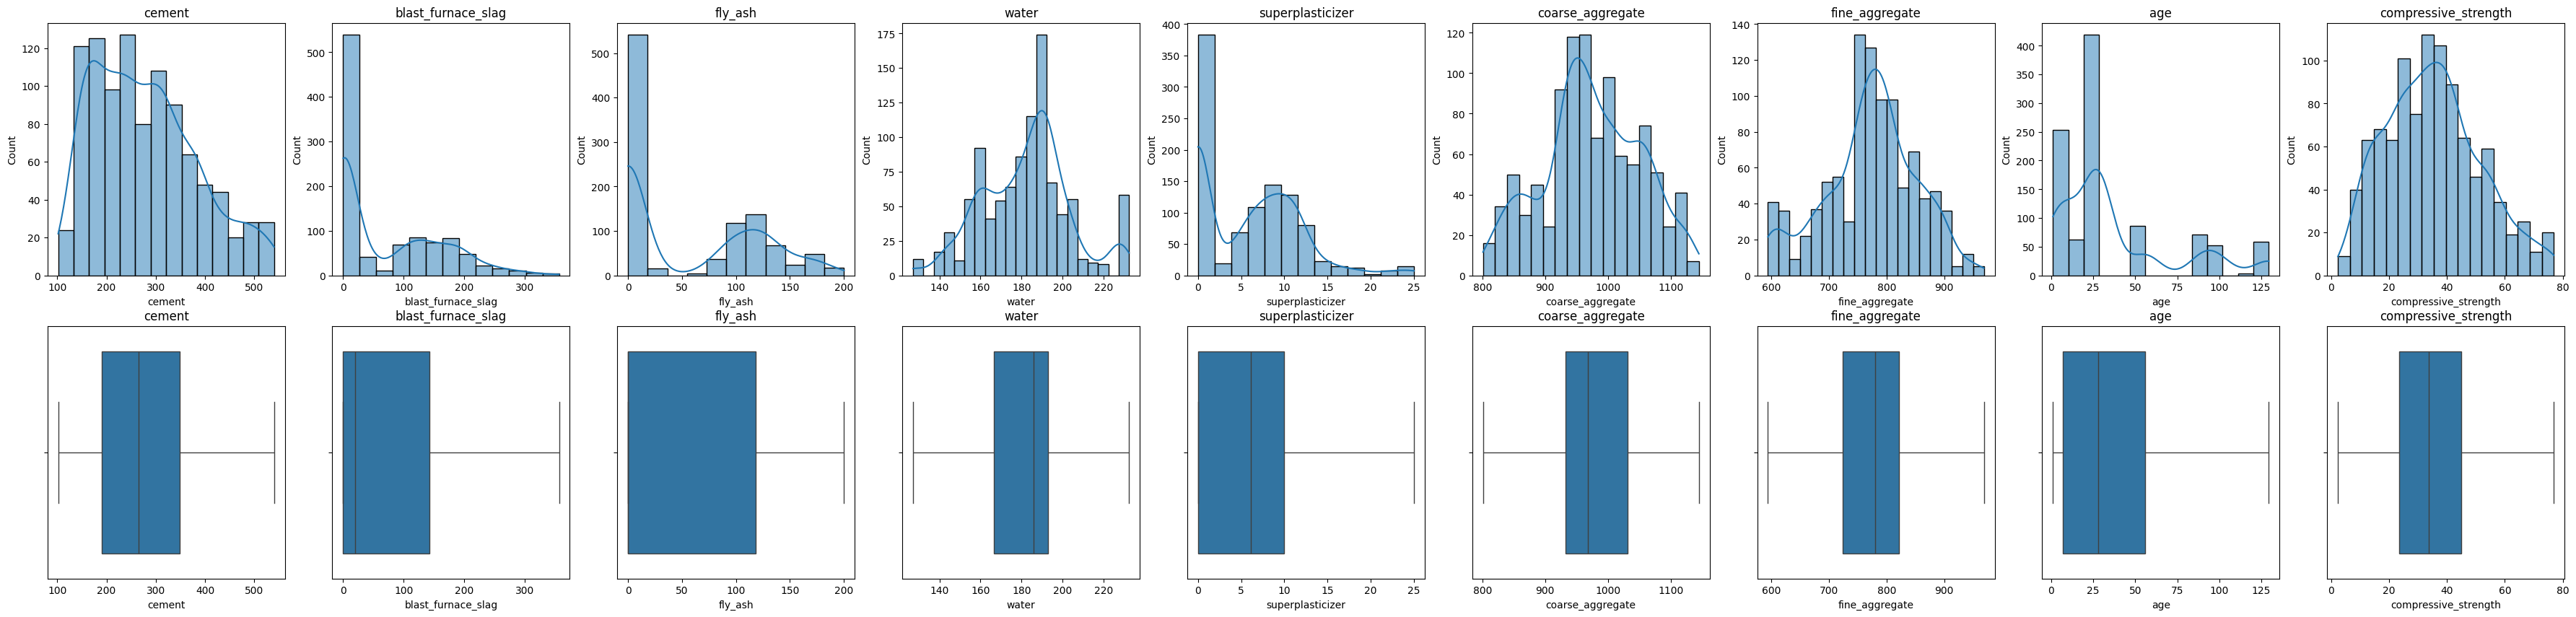

In [ ]:
if num_cols:
    fig, ax = plt.subplots(2, len(num_cols), figsize=(5 * len(num_cols), 10))
    for i, c in enumerate(num_cols):
        sns.histplot(df_concrete[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
        sns.boxplot(x=df_concrete[c], ax=ax[1, i]); ax[1, i].set_title(c)
    plt.show()

The outlier values of each feature were constrained to the corresponding lower and upper thresholds. Although this method introduces some bias into the data, it reduces variability and preserves all 1,006 records. In other words, no records were deleted for this reason.

In [ ]:
df_concrete.describe()

cement  blast_furnace_slag      fly_ash        water  \
count  1005.000000         1005.000000  1005.000000  1005.000000   
mean    278.631343           72.037214    55.536318   182.066816   
std     104.344261           86.149994    64.207969    21.158645   
min     102.000000            0.000000     0.000000   127.150000   
25%     190.700000            0.000000     0.000000   166.600000   
50%     265.000000           20.000000     0.000000   185.700000   
75%     349.000000          142.500000   118.300000   192.900000   
max     540.000000          356.250000   200.100000   232.350000   

       superplasticizer  coarse_aggregate  fine_aggregate          age  \
count       1005.000000       1005.000000     1005.000000  1005.000000   
mean           5.981493        974.376816      772.571095    38.076119   
std            5.724463         77.579667       80.035934    35.862549   
min            0.000000        801.000000      594.000000     1.000000   
25%            0.000000        932.000000      724.300000     7.000000   
50%            6.100000        968.000000      780.000000    28.000000   
75%           10.000000       1031.000000      822.200000    56.000000   
max           25.000000       1145.000000      969.050000   129.500000   

       compressive_strength  
count           1005.000000  
mean              35.226318  
std               16.220253  
min                2.330000  
25%               23.520000  
50%               33.800000  
75%               44.870000  
max               76.895000

After the analysis, and taking into account the age ranges and the presence of zeros in the 3 variables, a **logarithmic transformation logarithm(x+1)** will be used to reduce the range of non-zero values, seeking to improve the performance of the model by forming its cost function.

In [ ]:
variables_to_transform = ['fly_ash', 'superplasticizer', 'blast_furnace_slag', 'age']

In [ ]:
for var in variables_to_transform:
    df_concrete[f'{var}_log'] = np.log1p(df_concrete[var])

In [ ]:
df_concrete.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength',
       'Blast_used', 'Superplasticizer_used', 'fly_ash_log',
       'superplasticizer_log', 'blast_furnace_slag_log', 'age_log'],
      dtype='object')

In [ ]:
log_variables = ['fly_ash_log', 'superplasticizer_log', 'blast_furnace_slag_log', 'age_log']

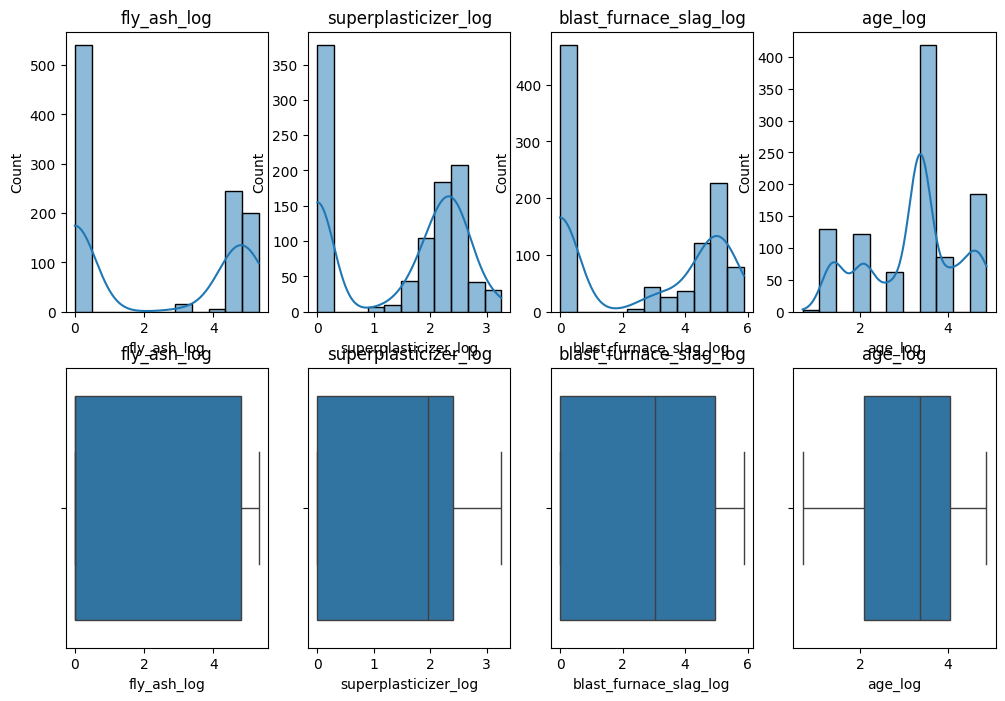

In [ ]:
if log_variables:
    fig, ax = plt.subplots(2, len(log_variables), figsize=(3 * len(log_variables), 8))
    for i, c in enumerate(log_variables):
        sns.histplot(df_concrete[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
        sns.boxplot(x=df_concrete[c], ax=ax[1, i]); ax[1, i].set_title(c)
    plt.show()

While zero-transformed variables logically cannot fit a normal distribution, their range of values ​​has been reduced from its original range to values ​​between 0 and 6. Age_log, on the other hand, does fit a bell-shaped distribution. Below are the variables that were most normal according to the Shapiro test, comparing their p-values.

In [ ]:
def more_normal(df, col1, col2):
    p1, p2 = shapiro(df_concrete[col1].dropna())[1], shapiro(df_concrete[col2].dropna())[1]
    return col1 if p1 > p2 else col2

In [ ]:
zip_variable = list(zip(variables_to_transform, log_variables))

for col1, col2 in zip_variable:
    console.print(f"More Normal: {more_normal(df_concrete, col1, col2)}")

More Normal: fly_ash

More Normal: superplasticizer

More Normal: blast_furnace_slag

More Normal: age_log

Unexpectedly, the untransformed variables, Fly Ash, Superplasticizer, and Explosion, **exhibit distributions closer to normal than the log-transformed ones**. However, due to range issues, the transformed variables will be retained.

## **Feature Engineering**

In [ ]:
df_concrete.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength',
       'Blast_used', 'Superplasticizer_used', 'fly_ash_log',
       'superplasticizer_log', 'blast_furnace_slag_log', 'age_log'],
      dtype='object')

In [ ]:
df_concrete = df_concrete.drop(columns=['Blast_used','Superplasticizer_used'])

### **Variable Selection**

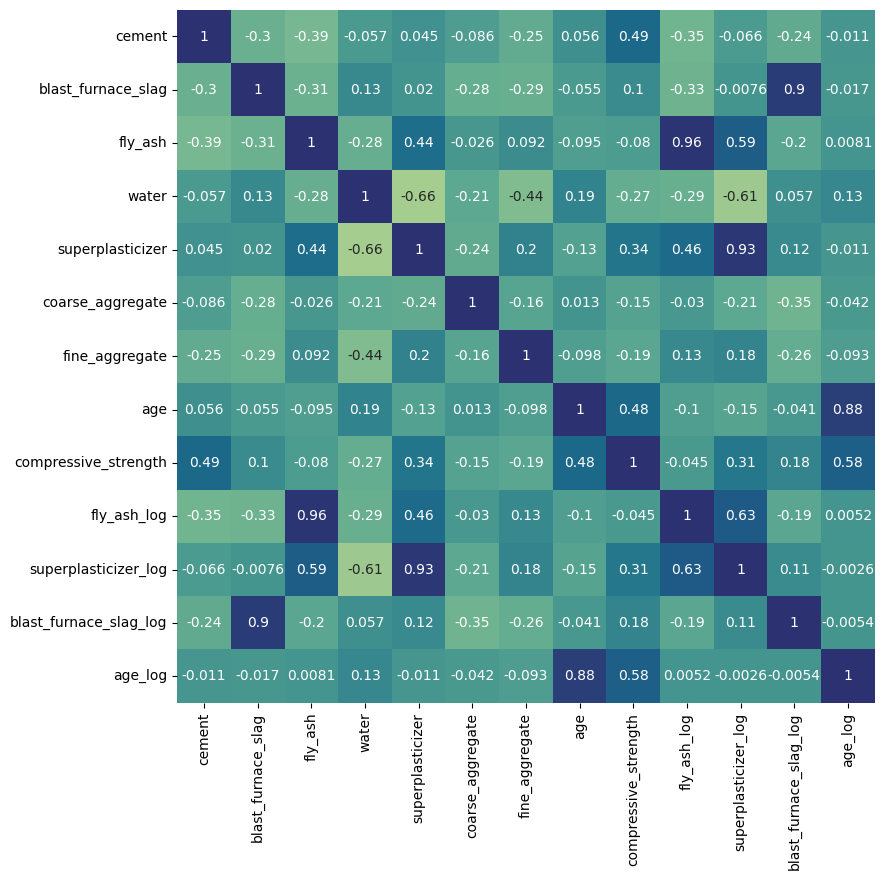

In [ ]:
plt.figure(figsize=(9,9))
correlation = df_concrete.corr()
sns.heatmap(correlation,cmap="crest",annot=True, cbar=False);

**STRENGTH OF CORRELATION BETWEEN *X* and *Y***

* The amount of cement has a moderate positive linear correlation (0.5) with compressive strength, indicating that mixes with more cement tend to have higher MPa.
* The Superplasticizer component has a moderate positive linear correlation (0.37) which decreases slightly with its transformation (0.34).
* The Age component has a moderate positive correlation (0.33) which increases to a strong positive correlation with its transformation Age\_log (0.55).
* The Fly Ash component and its transformation Fly Ash\_log have a very weak linear correlation with compressive strength.

**PRESENCE OF CORRELATION IN X - MULTICOLLINEARITY.**

Ignoring the nearly perfect relationships between variables and their transformations, it is observed that:

* A moderate positive correlation exists between Fly Ash and Superplasticizer (0.38), which becomes strong (0.56) with transformations.
* Water has strong negative correlations with Superplasticizer (-0.66) and with Fine aggregate (-0.61); however, these are not above the |0.8| threshold.

**VARIABLE DISCARDING**

**Fly Ash and its transformation are discarded** because they show a weak linear correlation with compressive strength (*Y*), indicating little to no linear relationship. Fly Ash also did not show significant differences between the medians of *Y* when comparing concrete mixes with or without the presence of this component. Its transformation is also discarded.

**The Superplasticizer\_log component is also discarded** because, upon reviewing the results, the range of the original variable [Superplasticizer] is only between 0 and 30, it is considered "more normal", and there is no improvement in correlation upon transformation.

**The Age feature is discarded** because, in terms of correlation, its transformation Age\_log improves its correlation with *Y*.

Finally, although the Water feature has strong negative correlations (-0.66 with Superplasticizer and -0.61 with Fine aggregate) with 2 other components, these features are retained, as the discarding threshold for correlations is set at |0.8|.

In [ ]:
df_concrete.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength',
       'fly_ash_log', 'superplasticizer_log', 'blast_furnace_slag_log',
       'age_log'],
      dtype='object')

In [ ]:
df_concrete_cleaned = df_concrete.drop(['fly_ash','fly_ash_log','superplasticizer_log','age','blast_furnace_slag'], axis=1)

In [ ]:
df_concrete_cleaned.columns

Index(['cement', 'water', 'superplasticizer', 'coarse_aggregate',
       'fine_aggregate', 'compressive_strength', 'blast_furnace_slag_log',
       'age_log'],
      dtype='object')

### **Zero Variance**

In [ ]:
df_concrete_cleaned.nunique()

cement                    278
water                     190
superplasticizer          110
coarse_aggregate          284
fine_aggregate            302
compressive_strength      838
blast_furnace_slag_log    185
age_log                    11
dtype: int64

There are not constant features into the dataset.

### **Featured Selected:**


In [ ]:
df_concrete_cleaned.columns

Index(['cement', 'water', 'superplasticizer', 'coarse_aggregate',
       'fine_aggregate', 'compressive_strength', 'blast_furnace_slag_log',
       'age_log'],
      dtype='object')

In [ ]:
df_concrete_cleaned.head()

cement  water  superplasticizer  coarse_aggregate  fine_aggregate  \
0   540.0  162.0               2.5            1040.0           676.0   
1   540.0  162.0               2.5            1055.0           676.0   
2   332.5  228.0               0.0             932.0           594.0   
3   332.5  228.0               0.0             932.0           594.0   
4   198.6  192.0               0.0             978.4           825.5   

   compressive_strength  blast_furnace_slag_log   age_log  
0                76.895                0.000000  3.367296  
1                61.890                0.000000  3.367296  
2                40.270                4.966335  4.871373  
3                41.050                4.966335  4.871373  
4                44.300                4.893352  4.871373

## **Division: Train and Test Sets**

In [ ]:
df_concrete_cleaned.columns

Index(['cement', 'water', 'superplasticizer', 'coarse_aggregate',
       'fine_aggregate', 'compressive_strength', 'blast_furnace_slag_log',
       'age_log'],
      dtype='object')

In [ ]:
y = df_concrete_cleaned["compressive_strength"]
X = df_concrete_cleaned.drop(columns=["compressive_strength"])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((703, 7), (302, 7), (703,), (302,))

**A 30% split is chosen**, which provides slightly more information for the test. However, a larger split is not chosen, as there are only 1,030 observations.

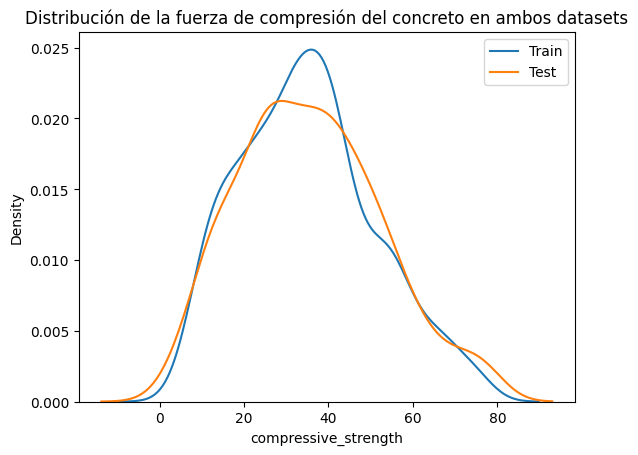

In [ ]:
sns.kdeplot(y_train, label='Train')
sns.kdeplot(y_test, label='Test')
plt.title('Distribución de la fuerza de compresión del concreto en ambos datasets')
plt.legend()
plt.show()

In [ ]:
stat, p = mannwhitneyu(y_train, y_test, alternative='two-sided')
if p < 0.05:
    console.print(f"With a p-value of {p:.3f}", "Reject H0: There are significant differences between the medians of both groups")
else:
    console.print(f"With a p-value of {p:.3f}", "Does not reject H0: There are no significant differences between the medians of the distributions compared")

With a p-value of 0.605 Does not reject H0: There are no significant differences between the medians of the 
distributions compared

It can be concluded both graphically and by non-parametric statistical test that the distributions of concrete compressive strength are equal in the test and training data sets, therefore the data set was appropriately split to proceed with the modeling stage.

### **Standardization Variables**

In [ ]:
scaler = StandardScaler()

standar_model = scaler.fit(X_train)

# Escalar características de entrenamiento y prueba
X_train_scaled = standar_model.transform(X_train)
X_test_scaled = standar_model.transform(X_test)

X_train_stan_df = pd.DataFrame(X_train_scaled)
X_train_stan_df.columns = X_train.columns
X_train_stan_df.describe()

cement         water  superplasticizer  coarse_aggregate  \
count  7.030000e+02  7.030000e+02      7.030000e+02      7.030000e+02   
mean   2.274141e-17 -1.288680e-16      2.097263e-16      6.519204e-16   
std    1.000712e+00  1.000712e+00      1.000712e+00      1.000712e+00   
min   -1.684076e+00 -2.625737e+00     -1.049605e+00     -2.221650e+00   
25%   -8.311226e-01 -7.256740e-01     -1.049605e+00     -5.341360e-01   
50%   -1.491459e-01  1.800305e-01      4.346205e-02     -7.039172e-02   
75%    6.207343e-01  4.819320e-01      6.854219e-01      7.205499e-01   
max    2.546884e+00  2.415539e+00      3.287962e+00      2.071849e+00   

       fine_aggregate  blast_furnace_slag_log       age_log  
count    7.030000e+02            7.030000e+02  7.030000e+02  
mean     1.096641e-15            1.339216e-16  5.053647e-17  
std      1.000712e+00            1.000712e+00  1.000712e+00  
min     -2.269692e+00           -1.056041e+00 -2.477864e+00  
25%     -5.120880e-01           -1.056041e+00 -5.068082e-01  
50%      9.319623e-02            2.504532e-01  1.380913e-01  
75%      6.427639e-01            1.011576e+00  7.991414e-01  
max      2.479510e+00            1.393379e+00  1.609438e+00

**Select Standardization because:**

**Unknown or Non-Gaussian Distribution:** When the distribution of data is not known or does not follow a normal (Gaussian) pattern. For example in linear regression, we may want to normalize the dependent variable so it looks more like a bell curve, which allows for better confidence in our estimates.

### **Denormalize Function**

In [ ]:
def denormalize(scaler, theta, scaler_type="Standard"):
    bias = theta[0] - np.sum(theta[1:] * (scaler.mean_ / scaler.scale_)) if scaler_type=="Standard" \
           else theta[0] + np.sum(theta[1:] * scaler.min_)
    coef = theta[1:] / scaler.scale_ if scaler_type=="Standard" else theta[1:] * scaler.scale_
    return np.r_[bias, coef]

## **Linear Regresion (GD)**

In [ ]:
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

# Imprimir los coeficientes del modelo
console.print(f"Intercept: {lr_model.intercept_}")
console.print(f"Coefficients: {lr_model.coef_}")


Intercept: 35.03553342816501

Coefficients: [ 7.76985601 -6.02822345  0.91463799 -1.41484189 -2.32351161  4.12478098
  9.68236454]

In [ ]:
thetas = [lr_model.intercept_] + list(lr_model.coef_)

### **Denormalize Thetas**

In [ ]:
thetas_denormalize = denormalize(scaler=standar_model, theta=thetas)
thetas_denormalize

array([ 7.14740190e+01,  7.50546832e-02, -2.88877738e-01,  1.58692132e-01,
       -1.82256905e-02, -2.94222785e-02,  1.71870882e+00,  9.47166334e+00])

In [ ]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

# Calcular residuos
y_pred = lr_model.predict(X_test)
residuos = y_test - y_pred

# Requerido por Breusch-Pagan y Durbin-Watson
X_test_const = sm.add_constant(X_test)

# --- Normalidad de los residuos (Shapiro-Wilk)
shapiro_test = shapiro(residuos)
pval_shapiro = shapiro_test.pvalue

# --- Homocedasticidad (Breusch-Pagan)
_, pval_bp, _, _ = het_breuschpagan(residuos, X_test_const)

# --- Independencia (Durbin-Watson)
dw_stat = durbin_watson(residuos)

# Mostrar resultados
print("🧪 Validación de supuestos de regresión lineal:\n")

print(f"1. Normalidad (Shapiro-Wilk): p = {pval_shapiro:.3f} → {'✅ Se cumple' if pval_shapiro > 0.05 else '❌ No se cumple'}")
print(f"2. Homocedasticidad (Breusch-Pagan): p = {pval_bp:.3f} → {'✅ Se cumple' if pval_bp > 0.05 else '❌ No se cumple'}")
print(f"3. Independencia (Durbin-Watson): DW = {dw_stat:.3f} → {'✅ Se cumple' if 1.5 < dw_stat < 2.5 else '❌ No se cumple'}")

🧪 Validación de supuestos de regresión lineal:

1. Normalidad (Shapiro-Wilk): p = 0.000 → ❌ No se cumple
2. Homocedasticidad (Breusch-Pagan): p = 0.000 → ❌ No se cumple
3. Independencia (Durbin-Watson): DW = 0.306 → ❌ No se cumple


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



## **Evaluación Regresión Lineal (GD)**

In [ ]:
# Función para calcular métricas
def calcular_metricas(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return [rmse, mae, r2, mape]

### **Training Dataset**

In [ ]:
# Predicciones Regresión Lineal
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Calcular métricas
metricas_train = calcular_metricas(y_train, y_train_pred)
metricas_test = calcular_metricas(y_test, y_test_pred)

rmse_train_lr = metricas_train[0]
rmse_test_lr = metricas_test[0]
mae_train_lr = metricas_train[1]
mae_test_lr = metricas_test[1]
r2_train_lr = metricas_train[2]
r2_test_lr = metricas_test[2]
mape_train_lr = metricas_train[3]
mape_test_lr = metricas_test[3]

# Crear DataFrame comparativo
tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

# Mostrar tabla
print("📊 Comparación de métricas del modelo:")
display(tabla_metricas.round(3))

📊 Comparación de métricas del modelo:


RMSE    MAE     R²  MAPE (%)
Train  6.936  5.471  0.811    19.037
Test   7.640  6.031  0.793    20.285

The model, overall, does not show signs of overfitting, as the performance metrics do not differ substantially between the training and test datasets. The multiple linear regression model yields an R² value of 0.793, indicating that approximately 79.3% of the total variation in concrete compressive strength is explained by the model. An RMSE of 7.640 suggests that the predictions deviate, on average, by around 7 MPa from the true values. Finally, a MAPE of 20.29% indicates that the model’s predictions deviate by approximately 20% on average.

It is worth noting that the model fails to meet the three classical assumptions: normality, homoscedasticity, and independence. This suggests that alternative models or model variations should be considered. In this case, regularization models are explored as the next step.

### **Test Dataset**

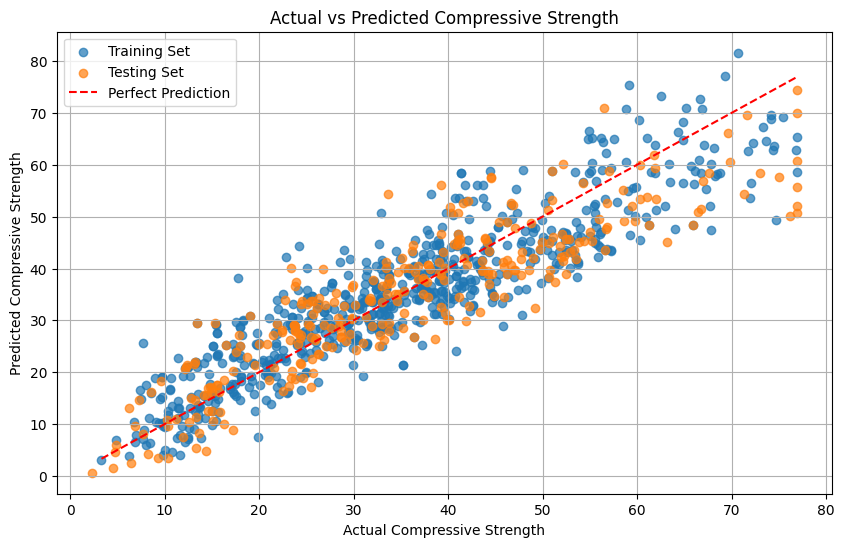

Difference in R^2 scores (Training - Testing): 0.017835009577615857

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_test_pred, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = r2_train_lr - r2_test_lr
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** If the predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well

## **Ridge Regularization**

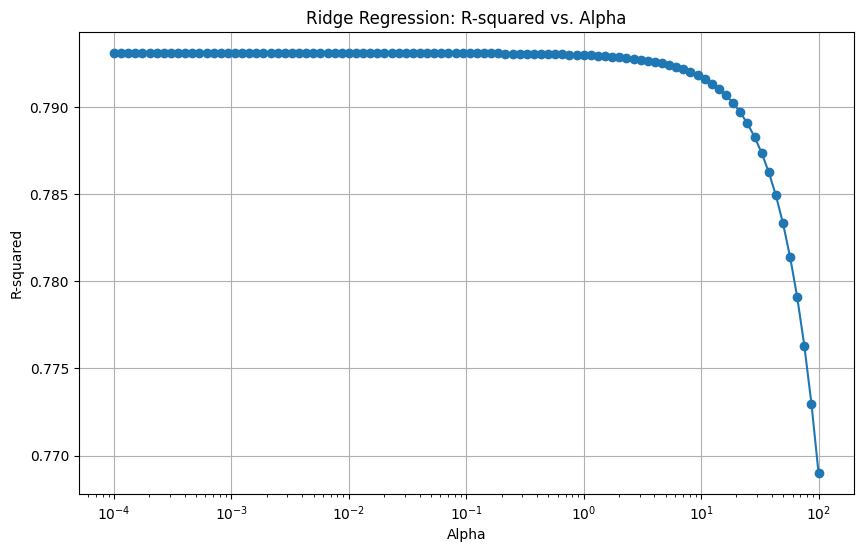

In [ ]:
alpha_vals = np.logspace(-4, 2, 100)
ridge_scores = []

for alpha in alpha_vals:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    ridge_scores.append(r2_score(y_test, y_pred_ridge))

plt.figure(figsize=(10, 6))
plt.plot(alpha_vals, ridge_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.yscale('linear')
plt.title('Ridge Regression: R-squared vs. Alpha')
plt.grid(True)
plt.show()


Keep in mind:
- **A low alpha** (poor regularization) can lead to overfitting, where the model overfits to the noise in the training data and does not generalize well to new data. A high R-squared in training is misleading in this case for generalization.
- **A high alpha** (high regularization) significantly penalizes the model's coefficients, reducing its complexity and helping prevent overfitting, thus improving generalization. However, if the alpha is too high, the model can become too simple and underfit the data, resulting in a low R-squared even with the training data (as seen on the far right of the graph).

**Taking an alpha where the curve begins to descend can be a good option to avoid extremes**

**This would be a number between 4 and 7**

### **Using GridSearchCV (Grid Search Cross-Validation):**
- Searches a grid of possible values ​​to find the best combination of hyperparameters for a model, using cross-validation. In this case, 5 splits (folds) of the original dataset are used and the performance of the training data and the dataset is calculated based on Rsquared.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': np.logspace(-4, 2, 100) # Probar 100 valores de alpha en escala logarítmica de 10^-4 a 10^2
}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,         # 5 Folds
                           scoring='r2', # Optimize R-squared
                           n_jobs=-1)

console.print("Starting Grid Search...")
grid_search.fit(X_train_scaled, y_train)
console.print("\nFinish Grid Search...")

console.print(f"\nBest parameters found: {grid_search.best_params_}")
console.print(f"Best score (R-squared): {grid_search.best_score_:.4f}")

Starting Grid Search...

Finish Grid Search...

Best parameters found: {'ridge__alpha': np.float64(4.037017258596558)}

Best score (R-squared): 0.8053

In [ ]:
console.print(f"Cross-validation tells us that the best value for alpha would be => {grid_search.best_params_['ridge__alpha']}")

Cross-validation tells us that the best value for alpha would be => 4.037017258596558

In [ ]:
alpha = grid_search.best_params_["ridge__alpha"]
ridge = Ridge(alpha=alpha, random_state=45)
ridge_model = ridge.fit(X_train_scaled, y_train)
coef_ridge = np.concatenate(([ridge_model.intercept_], ridge_model.coef_))
console.print("coefficients Ridge:\n", coef_ridge)

coefficients Ridge:
 [35.03553343  7.73973191 -5.90060418  1.00022979 -1.36686608 -2.27763476
  4.10759634  9.61590271]

### Ridge does **NOT remove features**, that is, it does not reach zero so it keeps all of them

In [ ]:
coef_ridge_orig = denormalize(scaler, coef_ridge)
console.print("Coeficientes GD (escala original):", coef_ridge_orig)

Coeficientes GD (escala original): [ 6.95289791e+01  7.47636927e-02 -2.82762111e-01  1.73542539e-01
 -1.76076764e-02 -2.88413469e-02  1.71154835e+00  9.40664781e+00]

In [ ]:
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)

metricas_train = calcular_metricas(y_train, y_pred_train_ridge)
metricas_test = calcular_metricas(y_test, y_pred_test_ridge)

rmse_train_ridge = metricas_train[0]
rmse_test_ridge = metricas_test[0]
mae_train_ridge = metricas_train[1]
mae_test_ridge = metricas_test[1]
r2_train_ridge = metricas_train[2]
r2_test_ridge = metricas_test[2]
mape_train_ridge = metricas_train[3]
mape_test_ridge = metricas_test[3]

tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

print(f"📊 Evaluación del modelo Ridge final (α = {grid_search.best_params_['ridge__alpha']}):")
display(tabla_metricas.round(3))

📊 Evaluación del modelo Ridge final (α = 4.037017258596558):


RMSE    MAE     R²  MAPE (%)
Train  6.937  5.468  0.811    19.018
Test   7.649  6.031  0.793    20.228

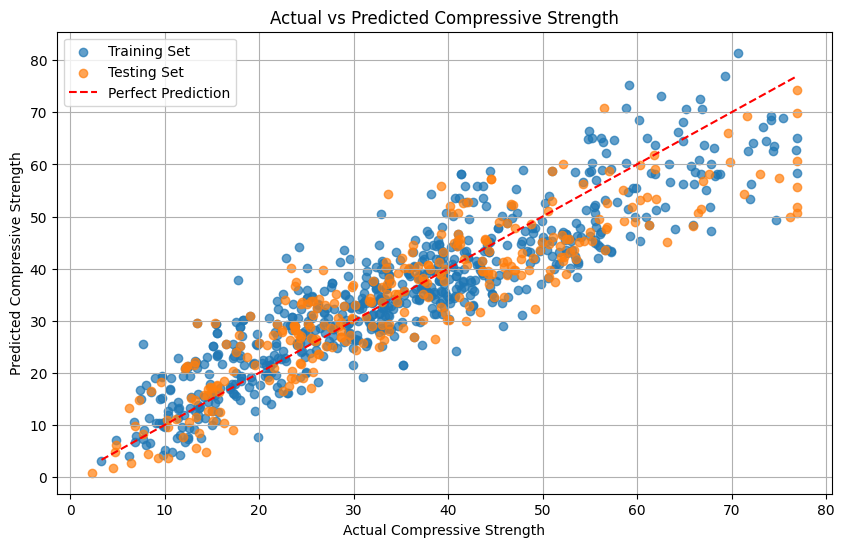

Difference in R^2 scores (Training - Testing): 0.018295712498142658

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_ridge, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_pred_test_ridge, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = tabla_metricas.iloc[0,2] - tabla_metricas.iloc[1,2]
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** The predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well

## **Lasso Regularization**

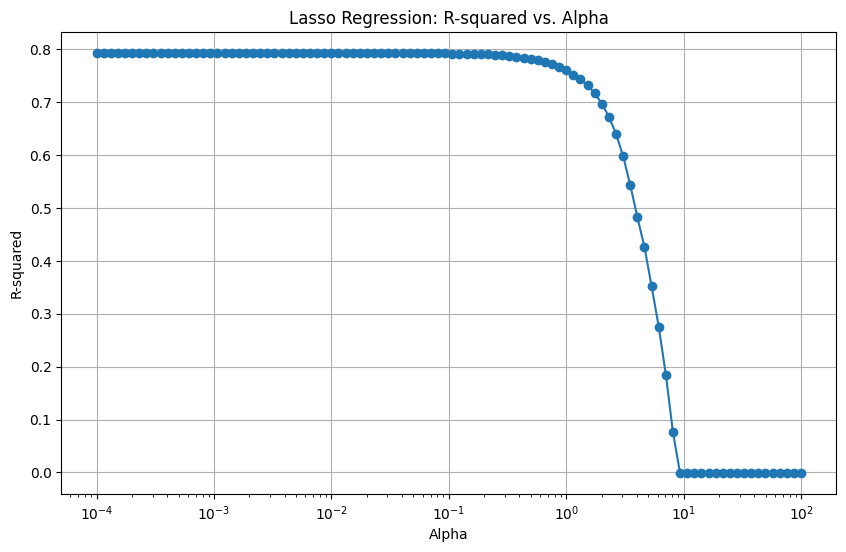

In [ ]:
alpha_vals = np.logspace(-4, 2, 100)
lasso_scores = []

for alpha in alpha_vals:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso_model.predict(X_test_scaled)
    lasso_scores.append(r2_score(y_test, y_pred_lasso))

plt.figure(figsize=(10, 6))
plt.plot(alpha_vals, lasso_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.yscale('linear')
plt.title('Lasso Regression: R-squared vs. Alpha')
plt.grid(True)
plt.show()


Keep in mind:
- **A low alpha** (poor regularization) can lead to overfitting, where the model overfits to the noise in the training data and does not generalize well to new data. A high R-squared in training is misleading in this case for generalization.
- **A high alpha** (high regularization) significantly penalizes the model's coefficients, reducing its complexity and helping prevent overfitting, thus improving generalization. However, if the alpha is too high, the model can become too simple and underfit the data, resulting in a low R-squared even with the training data (as seen on the far right of the graph).

**Taking an alpha where the curve begins to slope downward can be a good option to avoid extremes**

**This would be a number between 0.01 and 1**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('lasso', Lasso())
])

param_grid = {
    'lasso__alpha': np.logspace(-4, 2, 100) # Probar 100 valores de alpha en escala logarítmica de 10^-4 a 10^2
}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,         # 5 Folds
                           scoring='r2', # Optimize R-squared
                           n_jobs=-1)

console.print("Starting Grid Search...")
grid_search.fit(X_train_scaled, y_train)
console.print("\nFinish Grid Search...")

console.print(f"\nBest parameters found: {grid_search.best_params_}")
console.print(f"Best score (R-squared): {grid_search.best_score_:.4f}")

Starting Grid Search...

Finish Grid Search...

Best parameters found: {'lasso__alpha': np.float64(0.01519911082952933)}

Best score (R-squared): 0.8053

In [ ]:
console.print(f"Cross-validation tells us that the best value for alpha would be => {grid_search.best_params_['lasso__alpha']}")

Cross-validation tells us that the best value for alpha would be => 0.01519911082952933

In [ ]:
alpha_lasso = grid_search.best_params_['lasso__alpha']
Lasso_model = Lasso(alpha=alpha_lasso, random_state=42).fit(X_train_scaled, y_train)
coef_lasso = np.concatenate(([Lasso_model.intercept_], Lasso_model.coef_))
console.print("Coeficientes Lasso:\n", coef_lasso)

Coeficientes Lasso:
 [35.03553343  7.77339358 -5.9619079   0.943819   -1.36981084 -2.27457255
  4.13263679  9.66480346]

In [ ]:
coef_lasso_orig = denormalize(scaler, coef_lasso)
console.print("Coeficientes Lasso (escala original):", coef_lasso_orig)

Coeficientes Lasso (escala original): [ 6.98590051e+01  7.50888553e-02 -2.85699839e-01  1.63755116e-01
 -1.76456102e-02 -2.88025706e-02  1.72198217e+00  9.45448442e+00]

In [ ]:
y_pred_train_lasso = Lasso_model.predict(X_train_scaled)
y_pred_test_lasso = Lasso_model.predict(X_test_scaled)

metricas_train = calcular_metricas(y_train, y_pred_train_lasso)
metricas_test = calcular_metricas(y_test, y_pred_test_lasso)

rmse_train_lasso = metricas_train[0]
rmse_test_lasso = metricas_test[0]
mae_train_lasso = metricas_train[1]
mae_test_lasso = metricas_test[1]
r2_train_lasso = metricas_train[2]
r2_test_lasso = metricas_test[2]
mape_train_lasso = metricas_train[3]
mape_test_lasso = metricas_test[3]

tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

print(f"📊 Evaluación del modelo Ridge final (α = {grid_search.best_params_['lasso__alpha']}):")
display(tabla_metricas.round(3))

📊 Evaluación del modelo Ridge final (α = 0.01519911082952933):


RMSE    MAE     R²  MAPE (%)
Train  6.936  5.469  0.811    19.027
Test   7.641  6.029  0.793    20.249

The Lasso model is well-fitted, showing no signs of overfitting, with consistent metrics between training and test sets. Its performance (R² = 0.793, RMSE ≈ 7.64) is nearly identical to that of the linear and Ridge models. It does not provide significant improvements in accuracy. However, it offers the added benefit of automatic variable selection.

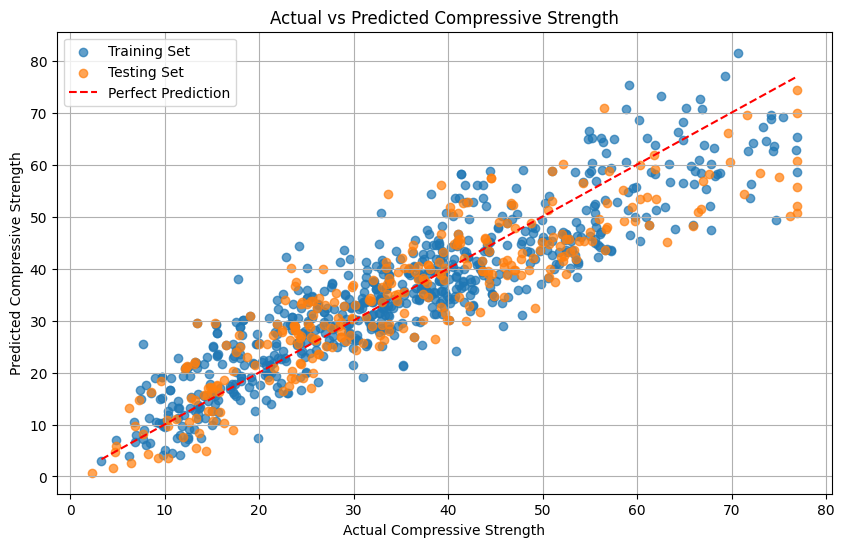

Difference in R^2 scores (Training - Testing): 0.017885180236420717

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_lasso, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_pred_test_lasso, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = r2_train_lasso - r2_test_lasso
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** The predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well

## **Polynomial Regression**

In [ ]:
poly_reg = PolynomialFeatures(degree=2)
X_poly_train = poly_reg.fit_transform(X_train)
X_poly_test = poly_reg.transform(X_test)

In [ ]:
poly_reg.get_feature_names_out()

array(['1', 'cement', 'water', 'superplasticizer', 'coarse_aggregate',
       'fine_aggregate', 'blast_furnace_slag_log', 'age_log', 'cement^2',
       'cement water', 'cement superplasticizer',
       'cement coarse_aggregate', 'cement fine_aggregate',
       'cement blast_furnace_slag_log', 'cement age_log', 'water^2',
       'water superplasticizer', 'water coarse_aggregate',
       'water fine_aggregate', 'water blast_furnace_slag_log',
       'water age_log', 'superplasticizer^2',
       'superplasticizer coarse_aggregate',
       'superplasticizer fine_aggregate',
       'superplasticizer blast_furnace_slag_log',
       'superplasticizer age_log', 'coarse_aggregate^2',
       'coarse_aggregate fine_aggregate',
       'coarse_aggregate blast_furnace_slag_log',
       'coarse_aggregate age_log', 'fine_aggregate^2',
       'fine_aggregate blast_furnace_slag_log', 'fine_aggregate age_log',
       'blast_furnace_slag_log^2', 'blast_furnace_slag_log age_log',
       'age_log^2'], dtype

In [ ]:
lr_polynomial_model = LinearRegression().fit(X_poly_train, y_train)
coef_ols = np.concatenate(([lr_polynomial_model.intercept_], lr_polynomial_model.coef_))
console.print("Polynomial coefficients:\n", coef_ols)

Polynomial coefficients:
 [-2.54021311e+03  5.22921774e-10  1.15416854e+00  7.02302603e+00
  1.67472534e+01  1.71412032e+00  2.13307026e+00  3.23175887e+01
  2.74378423e+01 -1.60330216e-04 -1.54752383e-03 -1.07336123e-03
 -2.86905481e-04 -4.80360498e-04 -1.17263921e-02 -2.69525290e-03
 -3.72442558e-03 -3.18482533e-02 -2.87691836e-03 -2.92009047e-03
 -3.38579743e-02 -6.71050347e-02 -1.05509147e-01 -4.79203790e-03
 -5.18721711e-03 -3.06157228e-02 -5.64490944e-02 -3.04025324e-04
 -6.16458498e-04 -1.54749299e-02  3.19342920e-04 -5.22244585e-04
 -1.34738721e-02 -6.67517335e-03  6.85912179e-01  3.12990657e-01
 -1.07013544e-01]

### **Evaluation**

In [ ]:
y_pred_train_polynomial = lr_polynomial_model.predict(X_poly_train)
y_pred_test_polynomial = lr_polynomial_model.predict(X_poly_test)

metricas_train = calcular_metricas(y_train, y_pred_train_polynomial)
metricas_test = calcular_metricas(y_test, y_pred_test_polynomial)

rmse_train_polynomial = metricas_train[0]
rmse_test_polynomial = metricas_test[0]
mae_train_polynomial = metricas_train[1]
mae_test_polynomial = metricas_test[1]
r2_train_polynomial = metricas_train[2]
r2_test_polynomial = metricas_test[2]
mape_train_polynomial = metricas_train[3]
mape_test_polynomial = metricas_test[3]

# Crear DataFrame comparativo
tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

# Mostrar tabla
print("📊 Comparación de métricas del modelo:")
display(tabla_metricas.round(3))

📊 Comparación de métricas del modelo:


RMSE    MAE     R²  MAPE (%)
Train  5.789  4.538  0.868    15.047
Test   6.715  5.032  0.840    16.817

The second-degree polynomial regression model shows improved performance compared to previous models, with higher R² (0.840) and lower RMSE (6.72) on the test set. The difference between training and test metrics remains moderate, indicating no overfitting. This model captures non-linear relationships more effectively. So far, it provides better predictive accuracy.

Conclusions:
- The higher the degree (example 4), the higher the R² with the training data, which indicates **overfitting**
- We have chosen **degree 2**

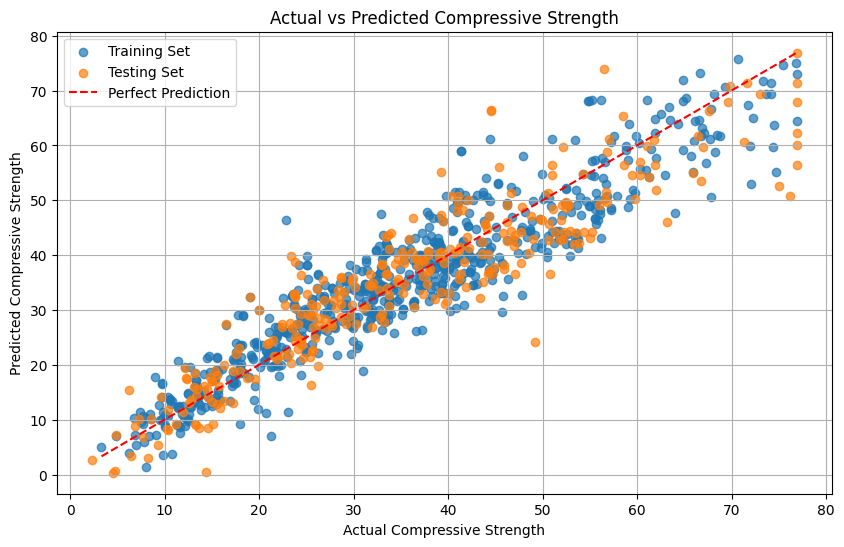

Difference in R^2 scores (Training - Testing): 0.02815264521577543

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_polynomial, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_pred_test_polynomial, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = r2_train_polynomial - r2_test_polynomial
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** The predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well

## **Support Vector Regression SVR**

In [ ]:
C = [.1,1,10,100,1000];
K = ['linear','poly','rbf','sigmoid']
f = make_subplots(1,4,subplot_titles=K)
for i, k in enumerate(K,1):
    r = [((m:=SVR(kernel=k, C=c).fit(X_train_scaled, y_train)).score(X_train_scaled, y_train), m.score(X_test_scaled, y_test)) for c in C]
    f.add_trace(go.Scatter(x=C, y=[t for t,_ in r],mode='lines',name='train_' + k), 1, i)
    f.add_trace(go.Scatter(x=C, y=[u for _,u in r],mode='lines',name='test_' + k), 1, i)
f.update_xaxes(type='log',title='C')
f.update_yaxes(title='$R^2$')
f.show()

**Conclusions:**
- **Higher initial score (0.9)**, outperforming linear and polygonal models.

- Smoother degradation with varying C, indicating greater robustness.

- Works well with nonlinear data (unlike linear data).

- Does not collapse like the sigmoid

- **The C value woulb be 10**

In [ ]:
svr_model = SVR(C = 10, kernel = 'rbf')
svr_model.fit(X_train_scaled, y_train)

SVR(C=10)

### **Evaluation**

In [ ]:
y_pred_train_svr = svr_model.predict(X_train_scaled)
y_pred_test_svr = svr_model.predict(X_test_scaled)

metricas_train = calcular_metricas(y_train, y_pred_train_svr)
metricas_test = calcular_metricas(y_test, y_pred_test_svr)

rmse_train_svr = metricas_train[0]
rmse_test_svr = metricas_test[0]
mae_train_svr = metricas_train[1]
mae_test_svr = metricas_test[1]
r2_train_svr = metricas_train[2]
r2_test_svr = metricas_test[2]
mape_train_svr = metricas_train[3]
mape_test_svr = metricas_test[3]

tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

console.print("📊 Evaluación del modelo SVR final C = 10 y Kernel=rbf")
display(tabla_metricas.round(3))

📊 Evaluación del modelo SVR final C = 10 y Kernel=rbf

RMSE    MAE     R²  MAPE (%)
Train  4.759  3.197  0.911    10.650
Test   6.314  4.207  0.859    14.106

The SVR model with RBF kernel and C=10, shows the best performance among all models tested, even better than the polinomial model, achieving an R² of 0.859 and the lowest RMSE (6.31) on the test set. The gap between training and test suggests no severe overfitting. Overall, it delivers the highest predictive accuracy in this analysis.

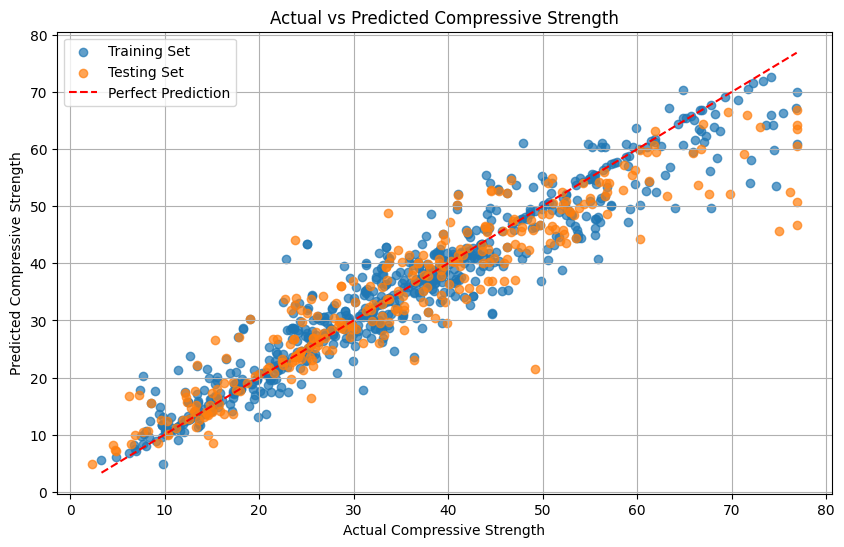

Difference in R^2 scores (Training - Testing): 0.052314413809238625

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_svr, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_pred_test_svr, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = r2_train_svr - r2_test_svr
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** The predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well


## Regresion Tree

In [ ]:
hp = [('max_leaf_nodes',range(2,40)),('max_depth',range(2,20)),('min_samples_leaf',range(1,30))]
fig = make_subplots(1,3,subplot_titles=[n.replace('_',' ').title() for n,_ in hp])

for i,(param,vals) in enumerate(hp,1):
    stats=[(m:=DecisionTreeRegressor(random_state=42)
             .set_params(**{param:v})
             .fit(X_train,y_train),
            m.score(X_train,y_train),
            m.score(X_test,y_test)) for v in vals]
    fig.add_trace(go.Scatter(x=list(vals), y=[t for _,t,_ in stats], mode='lines', name='train'), 1, i)
    fig.add_trace(go.Scatter(x=list(vals), y=[u for _,_,u in stats], mode='lines', name='test'),  1, i)
fig.show()

In [ ]:
DT_model = DecisionTreeRegressor(min_samples_leaf=18, random_state=42)
DT_model.fit(X_train_scaled,y_train)

DecisionTreeRegressor(min_samples_leaf=18, random_state=42)

In [ ]:
import graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz

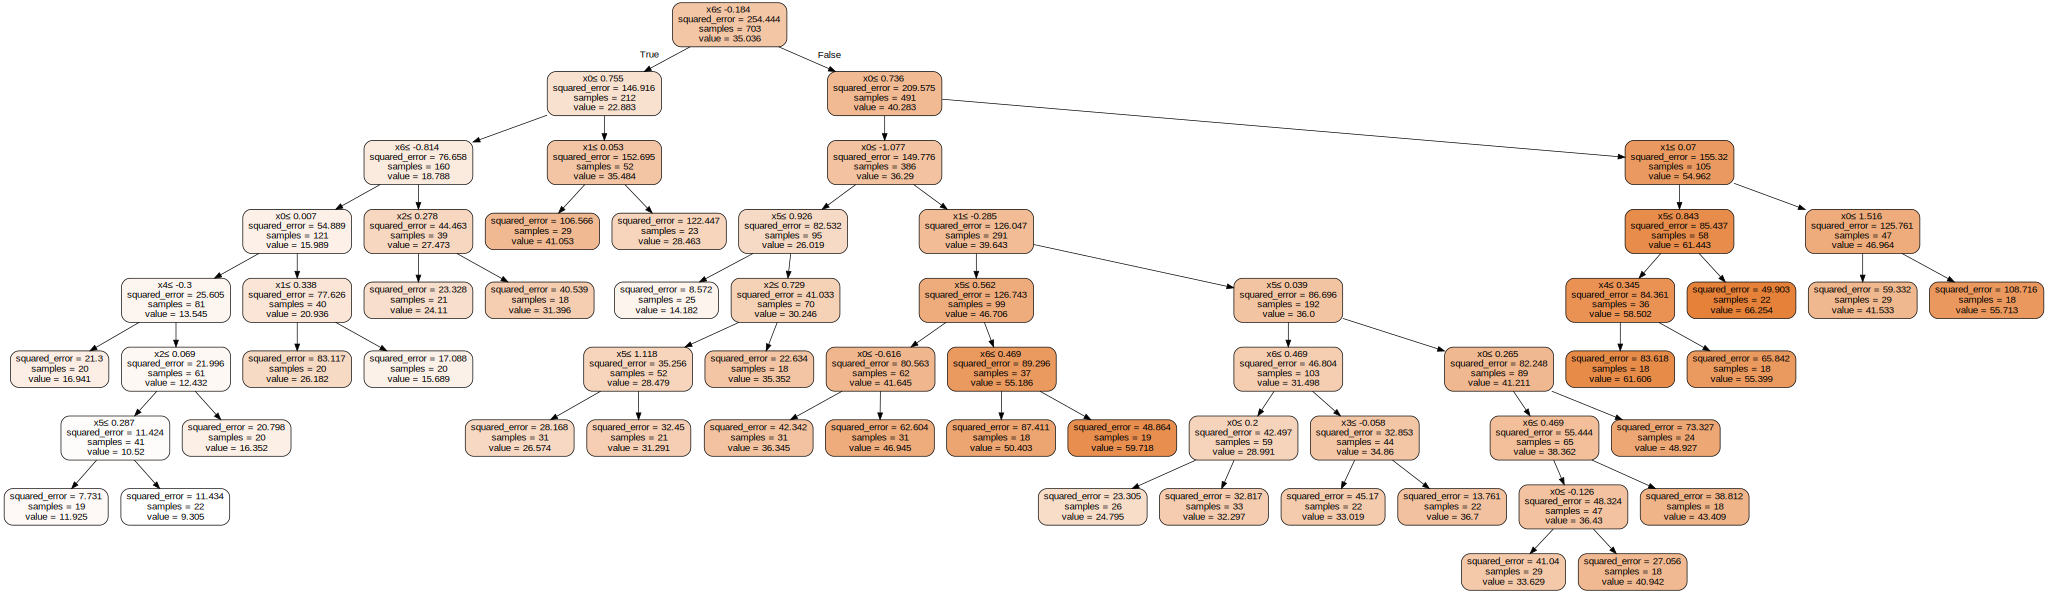

In [ ]:
dot_data = export_graphviz(DT_model, out_file = "arbol.dot", filled=True, rounded=True, special_characters=True)
with open("arbol.dot") as f:
  dot_data = f.read()
display(graphviz.Source(dot_data))

In [ ]:
y_pred_train_dt = DT_model.predict(X_train_scaled)
y_pred_test_dt = DT_model.predict(X_test_scaled)

metricas_train = calcular_metricas(y_train, y_pred_train_dt)
metricas_test = calcular_metricas(y_test, y_pred_test_dt)

rmse_train_dt = metricas_train[0]
rmse_test_dt = metricas_test[0]
mae_train_dt = metricas_train[1]
mae_test_dt = metricas_test[1]
r2_train_dt = metricas_train[2]
r2_test_dt = metricas_test[2]
mape_train_dt = metricas_train[3]
mape_test_dt = metricas_test[3]

tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

console.print("📊 Evaluación del modelo de Arbol final min_samples_leaf=18")
display(tabla_metricas.round(3))

📊 Evaluación del modelo de Arbol final min_samples_leaf=18

RMSE    MAE     R²  MAPE (%)
Train  6.840  5.194  0.816    17.550
Test   8.217  6.408  0.761    23.959

The Decision Tree model achieves a very high R² of 0.816 on the training set, indicating a near-perfect fit. However, the performance drops on the test set (R² = 0.76). Despite this, it still performs competitively, capturing complex relationships but with less generalization compared to SVR.

## **K Nearest Neighbors (KNN)**

**It is recommended to normalize the data with KNN**

Why?

Normalization is needed when using machine learning algorithms that rely on distances between data points, such as k-Nearest Neighbors (k-NN), to prevent features with larger scales from dominating the distance calculations.

In [ ]:
norm = MinMaxScaler()

norm_model = norm.fit(X_train)

X_train_norm = norm_model.transform(X_train)
X_test_norm = norm_model.transform(X_test)

In [ ]:
ks = range(1, 50)
scores = [(m := KNeighborsRegressor(n_neighbors=k,).fit(X_train_norm, y_train),
           m.score(X_train_norm, y_train),
           m.score(X_test_norm, y_test)) for k in ks]

fig = go.Figure([
    go.Scatter(x=list(ks), y=[t for _, t, _ in scores], mode='lines', name='train'),
    go.Scatter(x=list(ks), y=[u for _, _, u in scores], mode='lines', name='test')
])
fig.update_layout(xaxis_title='K', yaxis_title='Accuracy')
fig.show()

**Conclusions:**

- Relationship between Bias and Variance:
  - Lower K values ​​(such as K=1 or K=2) show slightly lower test accuracy and higher training accuracy, suggesting a greater risk of overfitting (high variance).
  - Higher K values ​​(K>3) show a decrease in test accuracy, indicating that the model is oversimplifying and may be underfitting (high bias).

In [ ]:
KNN_model = KNeighborsRegressor(n_neighbors=10,)
KNN_model.fit(X_train_norm, y_train)

KNeighborsRegressor(n_neighbors=10)

### **Evaluation**

In [ ]:
y_pred_train_knn = KNN_model.predict(X_train_norm)
y_pred_test_knn = KNN_model.predict(X_test_norm)

metricas_train = calcular_metricas(y_train, y_pred_train_knn)
metricas_test = calcular_metricas(y_test, y_pred_test_knn)

rmse_train_knn = metricas_train[0]
rmse_test_knn = metricas_test[0]
mae_train_knn = metricas_train[1]
mae_test_knn = metricas_test[1]
r2_train_knn = metricas_train[2]
r2_test_knn = metricas_test[2]
mape_train_knn = metricas_train[3]
mape_test_knn = metricas_test[3]

tabla_metricas = pd.DataFrame(
    [metricas_train, metricas_test],
    columns=['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    index=['Train', 'Test']
)

console.print("📊 Evaluación del modelo de KNN final n_neighbors=15")
display(tabla_metricas.round(3))

📊 Evaluación del modelo de KNN final n_neighbors=15

RMSE    MAE     R²  MAPE (%)
Train  6.070  4.584  0.855    16.760
Test   8.377  6.085  0.751    21.742

The KNN model shows reasonable performance on the training set with an R² of 0.855, but its test set metrics decline notably (R² = 0.753, RMSE = 8.34), indicating overfitting and lower generalization ability. The higher MAPE on test (21.68%) also reflects less accurate predictions compared to other models.

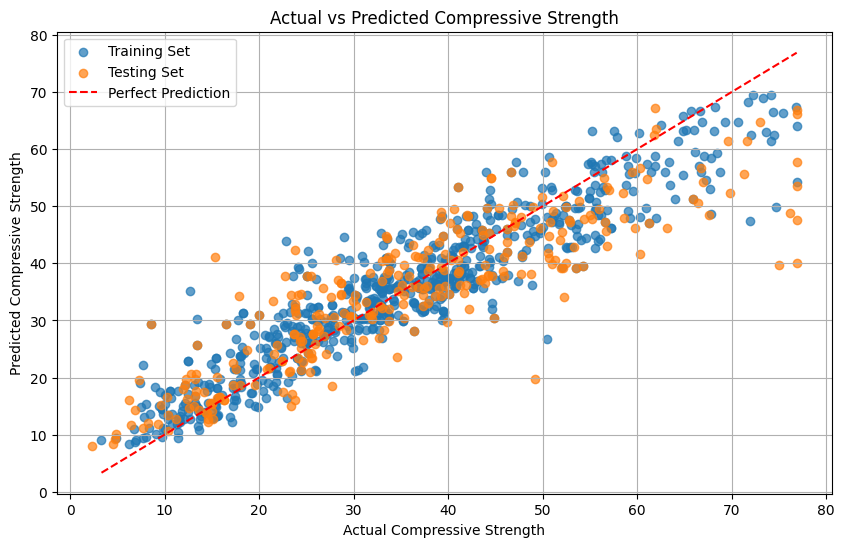

Difference in R^2 scores (Training - Testing): 0.10396723469567659

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_knn, label='Training Set', alpha=0.7)
plt.scatter(y_test, y_pred_test_knn, label='Testing Set', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Compressive Strength')
plt.ylabel('Predicted Compressive Strength')
plt.title('Actual vs Predicted Compressive Strength')
plt.legend()
plt.grid(True)
plt.show()

r2_diff = r2_train_knn - r2_test_knn
console.print(f"Difference in R^2 scores (Training - Testing): {r2_diff}")


### **Good fit:** The predictions on both sets are similar and reasonably close to the perfect prediction line, the model is generalizing well

## **Model Comparison**

In [ ]:
r2_scores = {
    'KNN': r2_train_knn,
    'Linear Regression': r2_train_lr,
    'Ridge Regression': r2_train_ridge,
    'Lasso Regression': r2_train_lasso,
    'Polynomial Regression': r2_train_polynomial,
    'SVR': r2_train_svr,
    'Decision Tree': r2_train_dt
}

sorted_r2 = dict(sorted(r2_scores.items(), key=lambda item: item[1],reverse=True))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(sorted_r2.keys()), y=list(sorted_r2.values())))
fig.update_layout(
    title="Comparison of R-squared Values for Different Regression Models - Test Dataset",
    xaxis_title="Regression Model",
    yaxis_title="R-squared",
    yaxis_range=[0, 1]
)
fig.show()


In [ ]:
r2_scores = {
    'KNN': r2_test_knn,
    'Linear Regression': r2_test_lr,
    'Ridge Regression': r2_test_ridge,
    'Lasso Regression': r2_test_lasso,
    'Polynomial Regression': r2_test_polynomial,
    'SVR': r2_test_svr,
    'Decision Tree': r2_test_dt
}

sorted_r2 = dict(sorted(r2_scores.items(), key=lambda item: item[1],reverse=True))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(sorted_r2.keys()), y=list(sorted_r2.values())))
fig.update_layout(
    title="Comparison of R-squared Values for Different Regression Models - Test Dataset",
    xaxis_title="Regression Model",
    yaxis_title="R-squared",
    yaxis_range=[0, 1]
)
fig.show()


In [ ]:
comparison_data = {
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Linear Regression Train': [rmse_train_lr, mae_train_lr, mape_train_lr],
    'Linear Regression Test': [rmse_test_lr, mae_test_lr, mape_test_lr],
    'Ridge Regression Train': [rmse_train_ridge, mae_train_ridge, mape_train_ridge],
    'Ridge Regression Test': [rmse_test_ridge, mae_test_ridge, mape_test_ridge],
    'Lasso Regression Train': [rmse_train_lasso, mae_train_lasso, mape_train_lasso],
    'Lasso Regression Test': [rmse_test_lasso, mae_test_lasso, mape_test_lasso],
    'Polynomial Regression Train': [rmse_train_polynomial, mae_train_polynomial, mape_train_polynomial],
    'Polynomial Regression Test': [rmse_test_polynomial, mae_test_polynomial, mape_test_polynomial],
    'KNN Train': [rmse_train_knn, mae_train_knn, mape_train_knn],
    'KNN Test': [rmse_test_knn, mae_test_knn, mape_test_knn],
    'SVR Train': [rmse_train_svr, mae_train_svr, mape_train_svr],
    'SVR Test': [rmse_test_svr, mae_test_svr, mape_test_svr],
    'Decision Tree Train': [rmse_train_dt, mae_train_dt, mape_train_dt],
    'Decision Tree Test': [rmse_test_dt, mae_test_dt, mape_test_dt]
}

comparison_df = pd.DataFrame(comparison_data)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Linear Regression Train'],
                         mode='lines+markers', name='Linear Regression Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Linear Regression Test'],
                         mode='lines+markers', name='Linear Regression Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Ridge Regression Train'],
                         mode='lines+markers', name='Ridge Regression Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Ridge Regression Test'],
                         mode='lines+markers', name='Ridge Regression Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Lasso Regression Train'],
                         mode='lines+markers', name='Lasso Regression Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Lasso Regression Test'],
                         mode='lines+markers', name='Lasso Regression Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Polynomial Regression Train'],
                         mode='lines+markers', name='Polynomial Regression Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Polynomial Regression Test'],
                         mode='lines+markers', name='Polynomial Regression Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['KNN Train'],
                         mode='lines+markers', name='KNN Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['KNN Test'],
                         mode='lines+markers', name='KNN Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['SVR Train'],
                         mode='lines+markers', name='SVR Train'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['SVR Test'],
                         mode='lines+markers', name='SVR Test'))
fig.add_trace(go.Scatter(x=comparison_df['Metric'], y=comparison_df['Decision Tree Train'],
                         mode='lines+markers', name='Decision Tree Train'))

fig.update_layout(title='Comparison of Regression Models',
                  xaxis_title='Metric',
                  yaxis_title='Value')
fig.show()


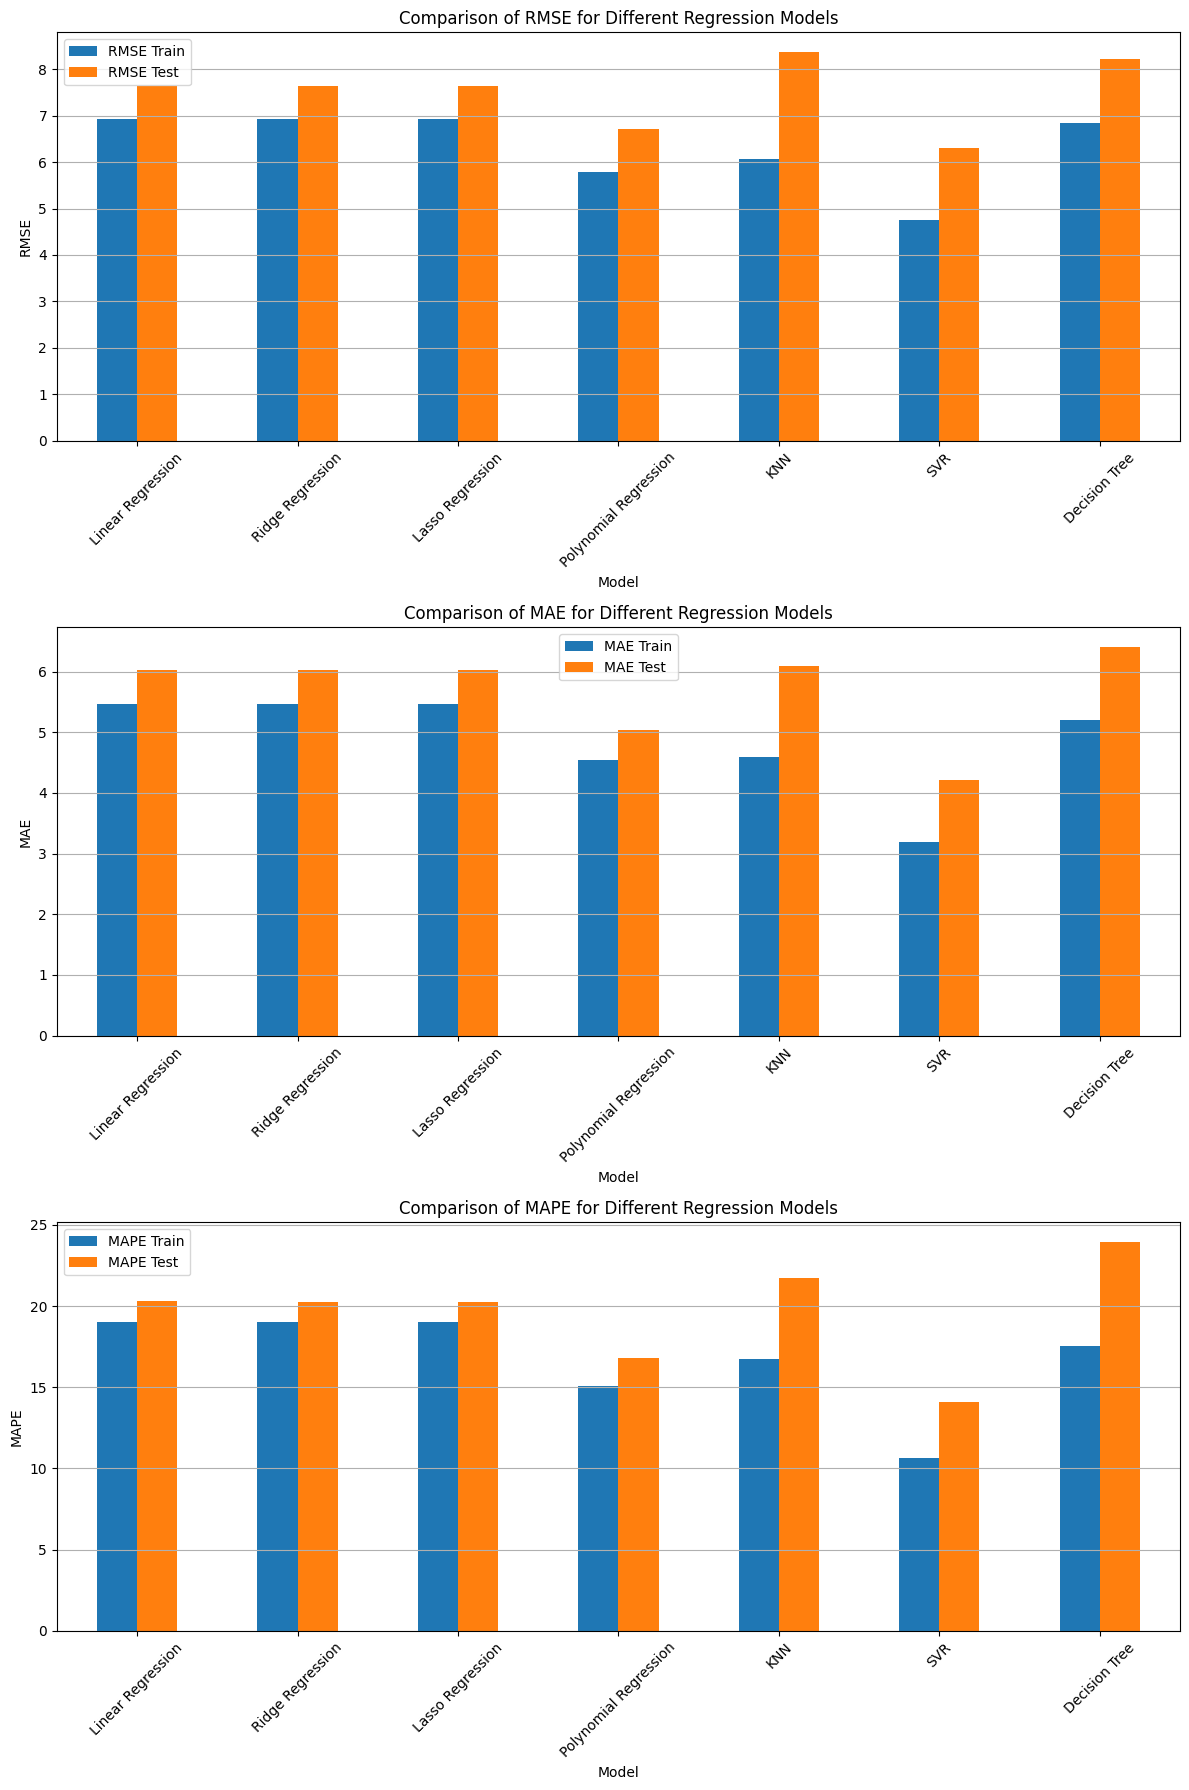

In [ ]:
metrics_rmse = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression', 'KNN', 'SVR', 'Decision Tree'],
    'RMSE Train': [rmse_train_lr, rmse_train_ridge, rmse_train_lasso, rmse_train_polynomial, rmse_train_knn, rmse_train_svr, rmse_train_dt],
    'RMSE Test': [rmse_test_lr, rmse_test_ridge, rmse_test_lasso, rmse_test_polynomial, rmse_test_knn, rmse_test_svr, rmse_test_dt]
}

metrics_mae = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression', 'KNN', 'SVR', 'Decision Tree'],
    'MAE Train': [mae_train_lr, mae_train_ridge, mae_train_lasso, mae_train_polynomial, mae_train_knn, mae_train_svr, mae_train_dt],
    'MAE Test': [mae_test_lr, mae_test_ridge, mae_test_lasso, mae_test_polynomial, mae_test_knn, mae_test_svr, mae_test_dt]
}

metrics_mape = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Polynomial Regression', 'KNN', 'SVR', 'Decision Tree'],
    'MAPE Train': [mape_train_lr, mape_train_ridge, mape_train_lasso, mape_train_polynomial, mape_train_knn, mape_train_svr, mape_train_dt],
    'MAPE Test': [mape_test_lr, mape_test_ridge, mape_test_lasso, mape_test_polynomial, mape_test_knn, mape_test_svr, mape_test_dt]
}

df_rmse = pd.DataFrame(metrics_rmse)
df_mae = pd.DataFrame(metrics_mae)
df_mape = pd.DataFrame(metrics_mape)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

df_rmse.plot(x='Model', y=['RMSE Train', 'RMSE Test'], kind='bar', ax=axes[0])
axes[0].set_title('Comparison of RMSE for Different Regression Models')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

df_mae.plot(x='Model', y=['MAE Train', 'MAE Test'], kind='bar', ax=axes[1])
axes[1].set_title('Comparison of MAE for Different Regression Models')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

df_mape.plot(x='Model', y=['MAPE Train', 'MAPE Test'], kind='bar', ax=axes[2])
axes[2].set_title('Comparison of MAPE for Different Regression Models')
axes[2].set_ylabel('MAPE')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y')

plt.tight_layout()
plt.show()


In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=y_train, y=y_train_pred, mode='markers', name='GD',
               marker=dict(color='cyan', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_ridge, mode='markers', name='Ridge',
               marker=dict(color='green', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_lasso, mode='markers', name='Lasso',
               marker=dict(color='red', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_polynomial, mode='markers', name='Polynomial',
               marker=dict(color='yellow', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_svr, mode='markers', name='SVR',
               marker=dict(color='blue', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_knn, mode='markers', name='KNN',
               marker=dict(color='gold', opacity=0.6)),
    go.Scatter(x=y_train, y=y_pred_train_dt, mode='markers', name='Decision Tree',
               marker=dict(color='gray', opacity=0.6)),


    go.Scatter(x=[y_train.min(), y_train.max()], y=[y_train.min(), y_train.max()], mode='lines', name='Ideal',
               line=dict(color='black', dash='dash'))

])
fig.update_yaxes(range=[y_train.min(), y_train.max()])
fig.update_xaxes(range=[y_train.min(), y_train.max()])
fig.update_layout(title="Performance: Training",
                  xaxis_title="compressive_strength (Real Data)",
                  yaxis_title="compressive_strength (Predicted)")
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Scatter(x=y_test, y=y_test_pred, mode='markers', name='GD',
               marker=dict(color='cyan', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_ridge, mode='markers', name='Ridge',
               marker=dict(color='green', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_lasso, mode='markers', name='Lasso',
               marker=dict(color='red', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_polynomial, mode='markers', name='Polynomial',
               marker=dict(color='yellow', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_svr, mode='markers', name='SVR',
               marker=dict(color='blue', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_knn, mode='markers', name='KNN',
               marker=dict(color='gold', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_dt, mode='markers', name='Decision Tree',
               marker=dict(color='gray', opacity=0.6)),

    go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], mode='lines', name='Ideal',
               line=dict(color='black', dash='dash'))
])
fig.update_yaxes(range=[y_test.min(), y_test.max()])
fig.update_xaxes(range=[y_test.min(), y_test.max()])
fig.update_layout(title="Performance: Test Data",
                  xaxis_title="compressive_strength (Real Data)",
                  yaxis_title="compressive_strength (Predicted)")
fig.show()

- Did overfitting occur in the trained models? If so, in which ones?
    
      R// We can say it did not occur, since a small difference between training and testing metrics suggests that the model generalizes well to unseen data, indicating it is not overfitting.
      Models with a large difference might be overfitting the training set.

      Although most models did not exhibit severe overfitting, the KNN model shows more pronounced overfitting compared to the others. This is evident when comparing the performance metrics across all models in a single plot, where the R² drops from 0.855 in training to 0.753 in testing — a decrease of approximately 10%.

      The plots of the actual versus predicted concrete compressive strength values show that most predictions align closely with the ideal diagonal line. However, for higher strength values, the model tends to underestimate the compressive strength, and the variance of the predictions increases in this range.

- Does the selected dataset contain outliers? How were they identified?

      R// Yes, the dataset contains outliers, which were identified using a boxplot metrics generating the treshholds:
      lower_bound = Q1 - 1.5 * IQR

      upper_bound = Q3 + 1.5 * IQR

- Was it necessary to remove the outliers? Why or why not?

      R// The outliers were not removed; instead, Outliers were bounded to these limits in order to keep all records in the dataset. This approach resulted in lower variance, while assuming the risk of introducing some bias into the models.

- What transformations or additions were applied to the variables in this case to improve model performance?

      R// A log(x + 1) transformation was applied to variables with a high presence of zeros and large value ranges, to control for scale differences.
      Subsequently, for models such as SVR and KNN, both standardization (scaling to zero mean and unit variance) and normalization (scaling to a [0, 1] range) were used during preprocessing.

**The Support Vector Regression (SVR) model with an RBF kernel demonstrated the strongest overall performance among all evaluated models.** On the test set, it achieved the highest R² (0.859), indicating that it explains approximately 85.9% of the variability in concrete compressive strength. Additionally, it obtained the lowest RMSE (6.31 MPa), reflecting highly accurate predictions with minimal deviation from actual values.

The model also recorded the lowest MAE (4.21 MPa) and lowest MAPE (14.11%), indicating both a low average error magnitude and a low percentage error relative to true values. **These metrics collectively suggest that SVR offers the most precise and reliable predictions.**

Crucially, the difference between training and test performance remained small (R² of 0.911 in training vs. 0.859 in test), **demonstrating excellent generalization without signs of overfitting**. Its capacity to capture complex non-linear relationships, coupled with its robust performance metrics, makes SVR the most suitable and accurate model for predicting concrete compressive strength in this study.

In [ ]:
with open("best_model_svr.pkl", "wb") as f:
  pickle.dump(svr_model, f)

In [ ]:
with open("standard_scaler_model.pkl", "wb") as f:
  pickle.dump(standar_model, f)